In [6]:
import os
from collections import Counter
from PIL import Image, ImageOps
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from tensorflow.keras.regularizers import l2
import seaborn as sns
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.optimizers import Adam
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.image as mpimg
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [7]:
# Cesta k bird_dataset
base_dir = "bird_dataset"
subdirs = ["train", "validation", "test"]

# Funkcia na analýzu datasetu
def analyze_dataset(base_dir, subdirs):
    class_counts = {}

    for subdir in subdirs:
        subdir_path = os.path.join(base_dir, subdir)
        classes = os.listdir(subdir_path)
        class_counts[subdir] = {cls: len(os.listdir(os.path.join(subdir_path, cls))) for cls in classes}
    
    return class_counts


# Analyzujeme dataset
class_counts = analyze_dataset(base_dir, subdirs)
print("Početnosť obrázkov v datasetoch:")
for subdir, counts in class_counts.items():
    print(f"{subdir}:")
    for cls, count in counts.items():
        print(f"  Trieda {cls}: {count} obrázkov")


Početnosť obrázkov v datasetoch:
train:
  Trieda 001.Black_footed_Albatross: 32 obrázkov
  Trieda 002.Laysan_Albatross: 32 obrázkov
  Trieda 003.Sooty_Albatross: 32 obrázkov
  Trieda 004.Groove_billed_Ani: 32 obrázkov
  Trieda 005.Crested_Auklet: 32 obrázkov
  Trieda 006.Least_Auklet: 32 obrázkov
  Trieda 007.Parakeet_Auklet: 32 obrázkov
  Trieda 008.Rhinoceros_Auklet: 32 obrázkov
  Trieda 009.Brewer_Blackbird: 32 obrázkov
  Trieda 010.Red_winged_Blackbird: 32 obrázkov
  Trieda 011.Rusty_Blackbird: 32 obrázkov
  Trieda 012.Yellow_headed_Blackbird: 32 obrázkov
  Trieda 013.Bobolink: 32 obrázkov
  Trieda 014.Indigo_Bunting: 32 obrázkov
  Trieda 015.Lazuli_Bunting: 32 obrázkov
  Trieda 016.Painted_Bunting: 32 obrázkov
  Trieda 017.Cardinal: 32 obrázkov
  Trieda 018.Spotted_Catbird: 32 obrázkov
  Trieda 019.Gray_Catbird: 32 obrázkov
  Trieda 020.Yellow_breasted_Chat: 32 obrázkov
  Trieda 021.Eastern_Towhee: 32 obrázkov
  Trieda 022.Chuck_will_Widow: 32 obrázkov
  Trieda 023.Brandt_Cormoran

In [ ]:

def display_representative_images_grid(base_dir, subdir, cols=4, max_images=16):
    subdir_path = os.path.join(base_dir, subdir)
    classes = os.listdir(subdir_path)
    
    for start_idx in range(0, len(classes), max_images):
        # Triedy pre aktuálnu mriežku (po 16)
        subset_classes = classes[start_idx:start_idx + max_images]
        num_classes = len(subset_classes)
        
        # Počet riadkov pre aktuálnu mriežku
        rows = (num_classes + cols - 1) // cols
        
        plt.figure(figsize=(cols * 3, rows * 3))  # Nastav veľkosť grafu
        
        for i, cls in enumerate(subset_classes):
            class_path = os.path.join(subdir_path, cls)
            image_path = os.path.join(class_path, os.listdir(class_path)[0])  # Prvý obrázok v triede
            image = Image.open(image_path)
            
            plt.subplot(rows, cols, i + 1)
            plt.imshow(image)
            plt.title(cls, fontsize=10)
            plt.axis("off")
        
        plt.tight_layout()
        plt.show()

# Zavoláme funkciu na zobrazenie obrázkov po 16 na mriežku
display_representative_images_grid(base_dir, "train", cols=4, max_images=16)


In [22]:

# Cesty k datasetu
train_dir = "bird_dataset/train"
val_dir = "bird_dataset/validation"
test_dir = "bird_dataset/test"

# Generátor dát s normalizáciou
datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Definícia modelu
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint(
    filepath='best_model.keras',  # Ukladanie vo formáte .keras
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

# Trénovanie modelu
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, checkpoint]
)

# Vyhodnotenie modelu na testovacej množine
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Testovacia strata: {test_loss:.4f}')
print(f'Testovacia presnosť: {test_accuracy:.4f}')


Found 6400 images belonging to 200 classes.
Found 800 images belonging to 200 classes.
Found 800 images belonging to 200 classes.


c:\Users\mraff\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\mraff\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 98s 479ms/step - accuracy: 0.0043 - loss: 5.3990 - val_accuracy: 0.0162 - val_loss: 5.2951
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 95s 473ms/step - accuracy: 0.0119 - loss: 5.2495 - val_accuracy: 0.0288 - val_loss: 5.0301
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 104s 519ms/step - accuracy: 0.0356 - loss: 4.8935 - val_accuracy: 0.0500 - val_loss: 4.8041
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 109s 547ms/step - accuracy: 0.0992 - loss: 4.3763 - val_accuracy: 0.0437 - val_loss: 4.6893
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 100s 501ms/step - accuracy: 0.1929 - loss: 3.7249 - val_accuracy: 0.0475 - val_loss: 4.6996
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 110s 549ms/step - accuracy: 0.3344 - loss: 2.8587 - val_accuracy: 0.0550 - val_loss: 4.9260
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 103s 514ms/step - accuracy: 0.4702 - loss: 2.1776 - val_accuracy: 0.0525 - val_loss: 5.1800
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 124s 425ms/step - accuracy: 0.5849 - l

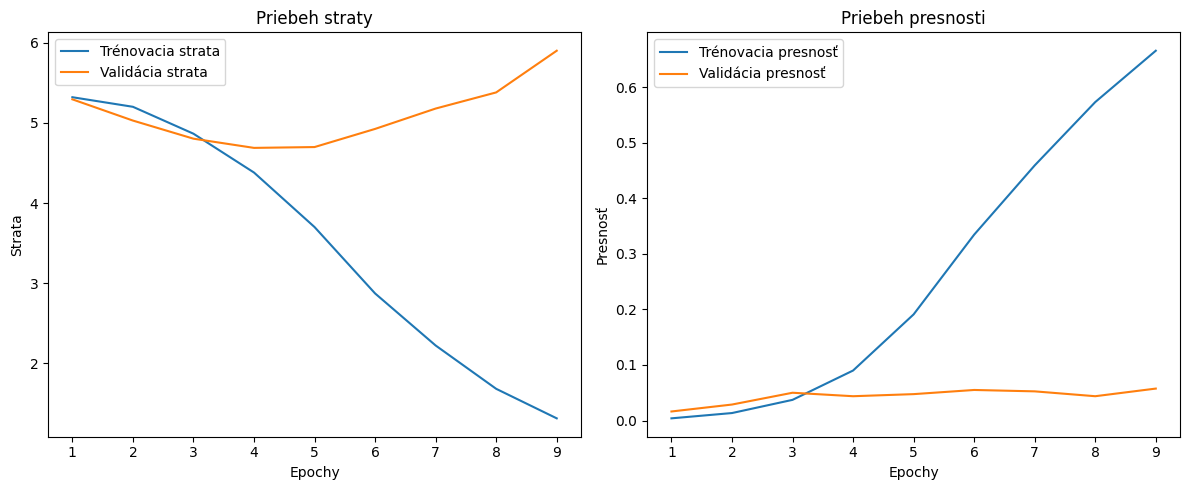

200/200 ━━━━━━━━━━━━━━━━━━━━ 42s 211ms/step


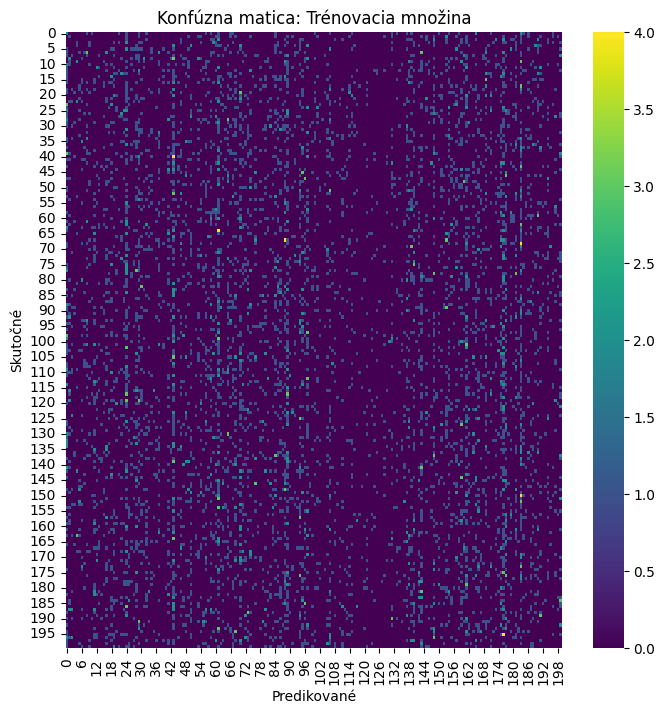

25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 181ms/step


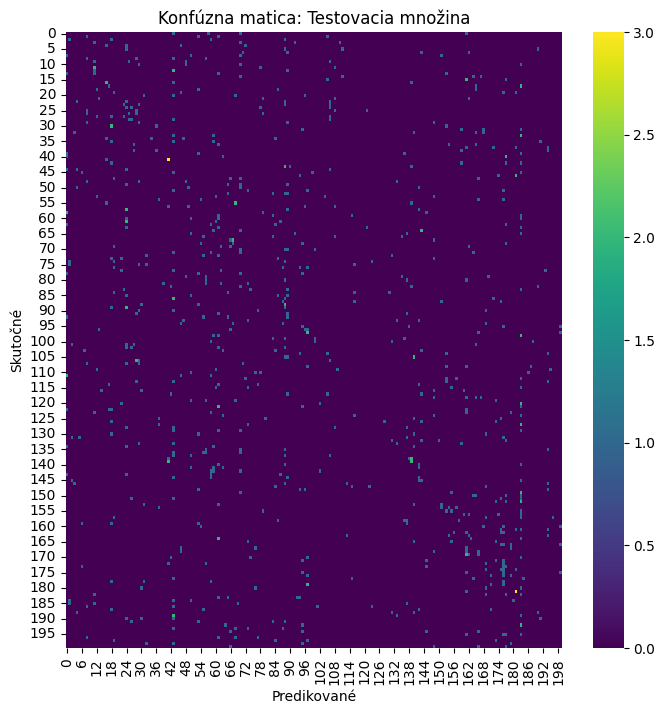

In [23]:
# Funkcia na vykreslenie priebehu trénovania
def plot_training_history(history):
    epochs = range(1, len(history.history['loss']) + 1)
    
    # Strata
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], label='Trénovacia strata')
    plt.plot(epochs, history.history['val_loss'], label='Validácia strata')
    plt.title('Priebeh straty')
    plt.xlabel('Epochy')
    plt.ylabel('Strata')
    plt.legend()
    
    # Presnosť
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['accuracy'], label='Trénovacia presnosť')
    plt.plot(epochs, history.history['val_accuracy'], label='Validácia presnosť')
    plt.title('Priebeh presnosti')
    plt.xlabel('Epochy')
    plt.ylabel('Presnosť')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Funkcia na vykreslenie zjednodušenej konfúznej matice
def plot_confusion_matrix(generator, dataset_name):
    y_true = generator.classes
    y_pred = np.argmax(model.predict(generator), axis=1)
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=False, cmap='viridis', cbar=True)
    plt.title(f'Konfúzna matica: {dataset_name}')
    plt.xlabel('Predikované')
    plt.ylabel('Skutočné')
    plt.show()

# Vykreslenie priebehu trénovania
plot_training_history(history)

# Vykreslenie konfúznych matíc
plot_confusion_matrix(train_generator, "Trénovacia množina")
plot_confusion_matrix(test_generator, "Testovacia množina")

Testovacia strata: 4.9773
Testovacia presnosť: 0.0325

In [30]:
# Rozšírenie augmentácie dát
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Upravená architektúra modelu
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001), input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.3),  # Zvýšený dropout

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Dropout(0.3),  # Zvýšený dropout

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),  # Ešte jeden dropout
    Dense(train_generator.num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks so zníženým patience
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint(
    filepath='best_model.keras',
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

# Trénovanie modelu
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, checkpoint]
)

# Vyhodnotenie modelu na testovacej množine
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Testovacia strata: {test_loss:.4f}')
print(f'Testovacia presnosť: {test_accuracy:.4f}')

Found 6400 images belonging to 200 classes.
Found 800 images belonging to 200 classes.
Found 800 images belonging to 200 classes.


c:\Users\mraff\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\mraff\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 138s 680ms/step - accuracy: 0.0024 - loss: 5.6766 - val_accuracy: 0.0050 - val_loss: 5.3731
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 223s 1s/step - accuracy: 0.0065 - loss: 5.3576 - val_accuracy: 0.0063 - val_loss: 5.3276
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 221s 1s/step - accuracy: 0.0053 - loss: 5.3198 - val_accuracy: 0.0088 - val_loss: 5.2798
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 145s 725ms/step - accuracy: 0.0071 - loss: 5.2876 - val_accuracy: 0.0088 - val_loss: 5.2602
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 157s 781ms/step - accuracy: 0.0067 - loss: 5.2609 - val_accuracy: 0.0088 - val_loss: 5.2208
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 148s 741ms/step - accuracy: 0.0092 - loss: 5.2502 - val_accuracy: 0.0075 - val_loss: 5.2193
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 172s 859ms/step - accuracy: 0.0082 - loss: 5.2453 - val_accuracy: 0.0100 - val_loss: 5.2042
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 164s 820ms/step - accuracy: 0.0079 - loss:

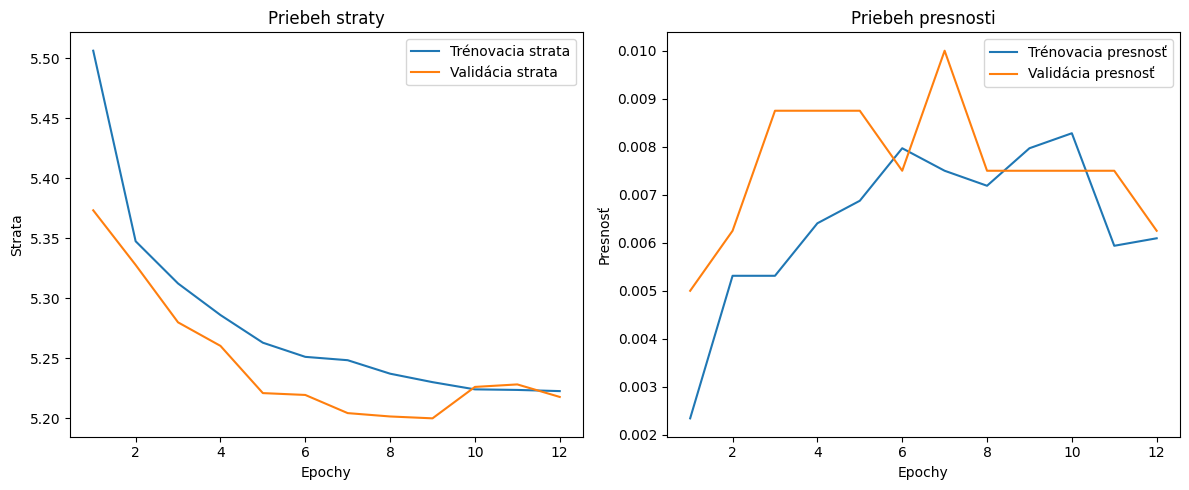

200/200 ━━━━━━━━━━━━━━━━━━━━ 62s 312ms/step


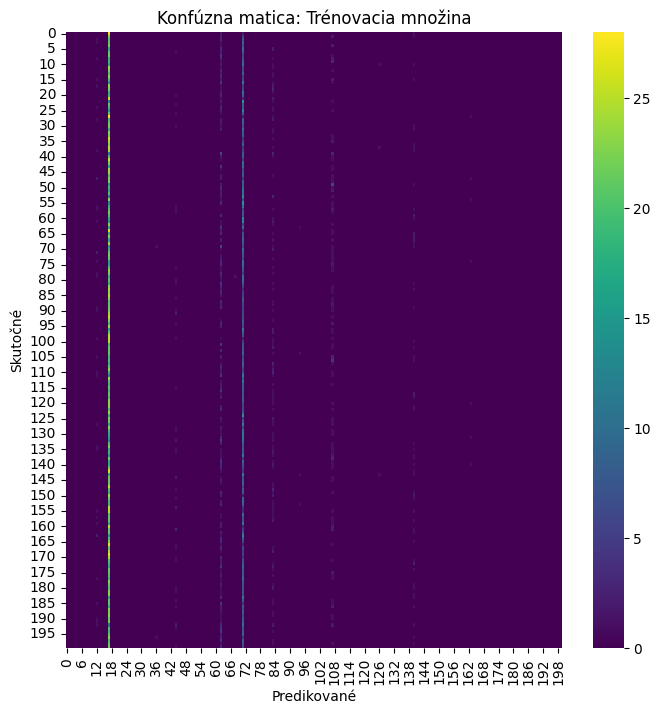

25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 345ms/step


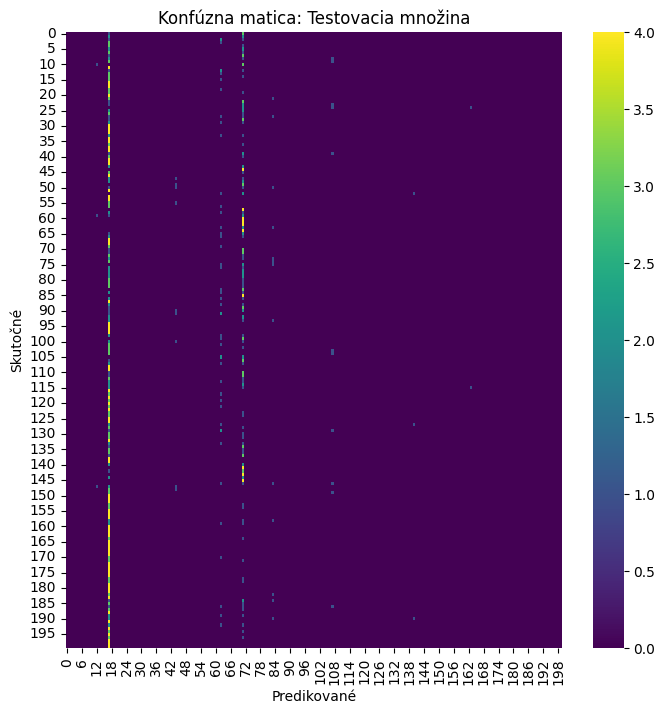

In [31]:
# Funkcia na vykreslenie priebehu trénovania
def plot_training_history(history):
    epochs = range(1, len(history.history['loss']) + 1)
    
    # Strata
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], label='Trénovacia strata')
    plt.plot(epochs, history.history['val_loss'], label='Validácia strata')
    plt.title('Priebeh straty')
    plt.xlabel('Epochy')
    plt.ylabel('Strata')
    plt.legend()
    
    # Presnosť
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['accuracy'], label='Trénovacia presnosť')
    plt.plot(epochs, history.history['val_accuracy'], label='Validácia presnosť')
    plt.title('Priebeh presnosti')
    plt.xlabel('Epochy')
    plt.ylabel('Presnosť')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Funkcia na vykreslenie zjednodušenej konfúznej matice
def plot_confusion_matrix(generator, dataset_name):
    y_true = generator.classes
    y_pred = np.argmax(model.predict(generator), axis=1)
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=False, cmap='viridis', cbar=True)
    plt.title(f'Konfúzna matica: {dataset_name}')
    plt.xlabel('Predikované')
    plt.ylabel('Skutočné')
    plt.show()

# Vykreslenie priebehu trénovania
plot_training_history(history)

# Vykreslenie konfúznych matíc
plot_confusion_matrix(train_generator, "Trénovacia množina")
plot_confusion_matrix(test_generator, "Testovacia množina")

In [74]:
# Cesty k datasetu
train_dir = "bird_dataset/train"
val_dir = "bird_dataset/validation"
test_dir = "bird_dataset/test"

# Upravená augmentácia dát
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

base_model = MobileNetV2(
    weights='imagenet',  # Načítanie váh trénovaných na ImageNet
    include_top=False,
    input_shape=(128, 128, 3)
)

base_model.trainable = False  # Zmrazenie váh základného modelu

# Vlastné vrstvy
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

# Kompilácia modelu s menším learning rate
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint(
    filepath='best_model.keras',
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

# Trénovanie modelu
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, checkpoint]
)

# Vyhodnotenie modelu na testovacej množine
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Testovacia strata: {test_loss:.4f}')
print(f'Testovacia presnosť: {test_accuracy:.4f}')


Found 6400 images belonging to 200 classes.
Found 800 images belonging to 200 classes.
Found 800 images belonging to 200 classes.


c:\Users\mraff\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 149s 727ms/step - accuracy: 0.0053 - loss: 5.8207 - val_accuracy: 0.0050 - val_loss: 5.5117
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 75s 377ms/step - accuracy: 0.0061 - loss: 5.5231 - val_accuracy: 0.0100 - val_loss: 5.4723
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 76s 380ms/step - accuracy: 0.0103 - loss: 5.4804 - val_accuracy: 0.0300 - val_loss: 5.4132
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 81s 404ms/step - accuracy: 0.0156 - loss: 5.4168 - val_accuracy: 0.0300 - val_loss: 5.3204
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 79s 396ms/step - accuracy: 0.0271 - loss: 5.3309 - val_accuracy: 0.0400 - val_loss: 5.2031
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 82s 410ms/step - accuracy: 0.0262 - loss: 5.2255 - val_accuracy: 0.0450 - val_loss: 5.0594
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 79s 396ms/step - accuracy: 0.0385 - loss: 5.1009 - val_accuracy: 0.0775 - val_loss: 4.8638
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 82s 409ms/step - accuracy: 0.0417 - loss: 

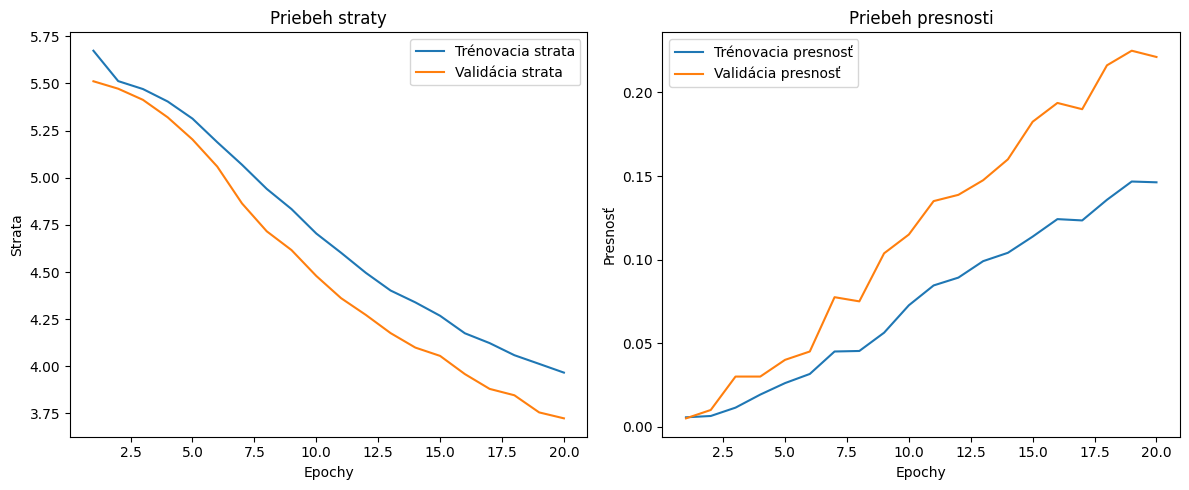

200/200 ━━━━━━━━━━━━━━━━━━━━ 62s 302ms/step


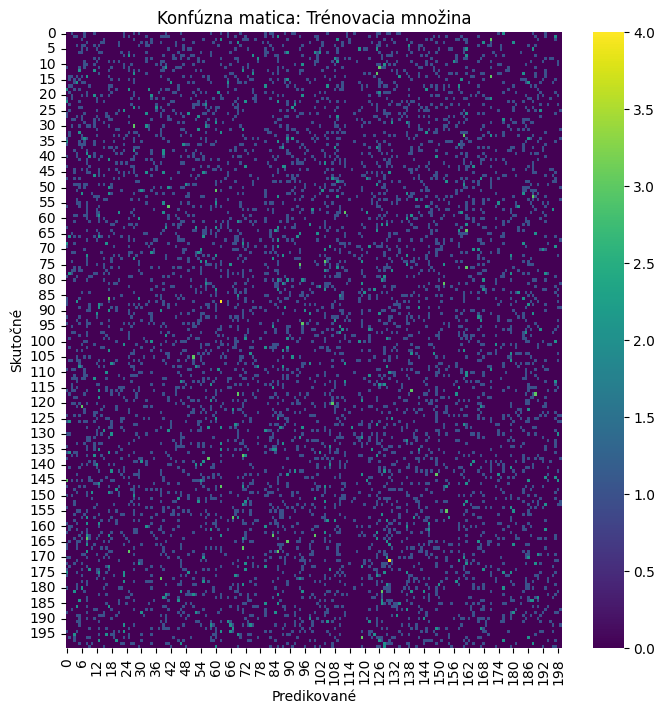

25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 373ms/step


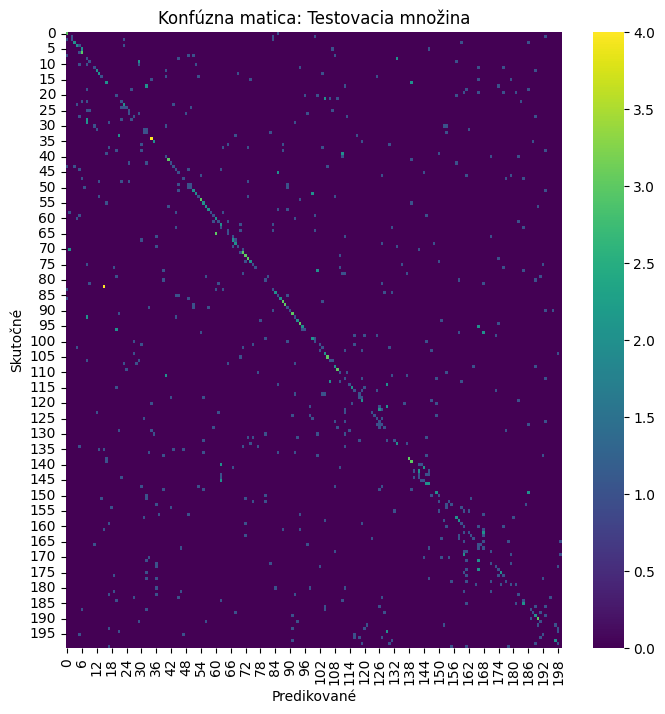

In [75]:
import tensorflow as tf

def get_predictions(model, dataset):
    y_pred = []
    y_true = []

    num_batches = len(dataset)
    for i, (image_batch, label_batch) in enumerate(dataset):
        if i >= num_batches:
            break
        y_true.append(np.argmax(label_batch, axis=-1))
        preds = model.predict(image_batch, verbose=1)
        y_pred.append(np.argmax(preds, axis=- 1))

    y_true_classes = tf.concat([item for item in y_true], axis=0)
    y_pred_classes = tf.concat([item for item in y_pred], axis=0)

    return y_true_classes, y_pred_classes

# Funkcia na vykreslenie priebehu trénovania
def plot_training_history(history):
    epochs = range(1, len(history.history['loss']) + 1)
    
    # Strata
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], label='Trénovacia strata')
    plt.plot(epochs, history.history['val_loss'], label='Validácia strata')
    plt.title('Priebeh straty')
    plt.xlabel('Epochy')
    plt.ylabel('Strata')
    plt.legend()
    
    # Presnosť
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['accuracy'], label='Trénovacia presnosť')
    plt.plot(epochs, history.history['val_accuracy'], label='Validácia presnosť')
    plt.title('Priebeh presnosti')
    plt.xlabel('Epochy')
    plt.ylabel('Presnosť')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Funkcia na vykreslenie zjednodušenej konfúznej matice
def plot_confusion_matrix(generator, dataset_name):
    y_true = generator.classes
    y_pred = np.argmax(model.predict(generator), axis=1)
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=False, cmap='viridis', cbar=True)
    plt.title(f'Konfúzna matica: {dataset_name}')
    plt.xlabel('Predikované')
    plt.ylabel('Skutočné')
    plt.show()

# Vykreslenie priebehu trénovania
plot_training_history(history)

# Vykreslenie konfúznych matíc
plot_confusion_matrix(train_generator, "Trénovacia množina")
plot_confusion_matrix(test_generator, "Testovacia množina")

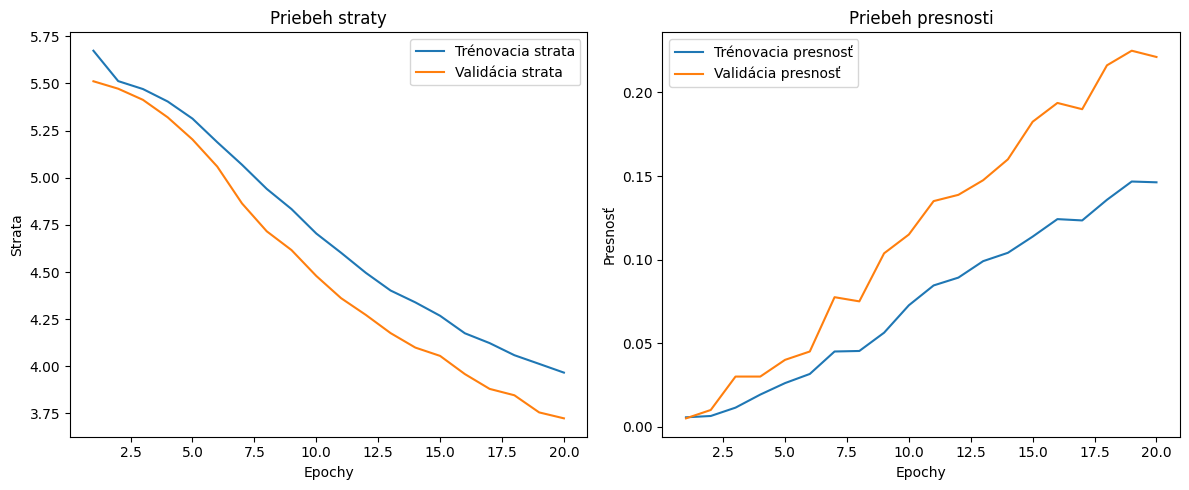

KeyboardInterrupt: 

In [76]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def get_predictions(model, dataset):
    y_pred = []
    y_true = []

    for image_batch, label_batch in dataset:
        y_true.append(np.argmax(label_batch, axis=-1))  # Skutočné triedy
        preds = model.predict(image_batch, verbose=0)   # Predikcie modelu
        y_pred.append(np.argmax(preds, axis=-1))        # Predikované triedy

    # Zlúčenie všetkých batchov do jedného zoznamu
    y_true_classes = tf.concat([tf.convert_to_tensor(item) for item in y_true], axis=0)
    y_pred_classes = tf.concat([tf.convert_to_tensor(item) for item in y_pred], axis=0)

    return y_true_classes.numpy(), y_pred_classes.numpy()

# Funkcia na vykreslenie priebehu trénovania
def plot_training_history(history):
    epochs = range(1, len(history.history['loss']) + 1)
    
    # Strata
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], label='Trénovacia strata')
    plt.plot(epochs, history.history['val_loss'], label='Validácia strata')
    plt.title('Priebeh straty')
    plt.xlabel('Epochy')
    plt.ylabel('Strata')
    plt.legend()
    
    # Presnosť
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['accuracy'], label='Trénovacia presnosť')
    plt.plot(epochs, history.history['val_accuracy'], label='Validácia presnosť')
    plt.title('Priebeh presnosti')
    plt.xlabel('Epochy')
    plt.ylabel('Presnosť')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Funkcia na vykreslenie konfúznej matice s použitím get_predictions
def plot_confusion_matrix_from_predictions(model, dataset, dataset_name):
    y_true, y_pred = get_predictions(model, dataset)  # Získanie predikcií
    cm = confusion_matrix(y_true, y_pred)            # Výpočet konfúznej matice
    
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
    plt.title(f'Konfúzna matica: {dataset_name}')
    plt.xlabel('Predikované triedy')
    plt.ylabel('Skutočné triedy')
    plt.show()

# Vykreslenie priebehu trénovania
plot_training_history(history)

# Vykreslenie konfúznej matice len pre trénovaciu množinu
plot_confusion_matrix_from_predictions(model, train_generator, "Trénovacia množina")


In [ ]:
# Upravená augmentácia dát
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

base_model = MobileNetV2(
    weights='imagenet',  # Načítanie váh trénovaných na ImageNet
    include_top=False,
    input_shape=(128, 128, 3)
)

base_model.trainable = False  # Zmrazenie váh základného modelu

# Upravená architektúra modelu
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.0005), input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.2), 

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.0005)),
    MaxPooling2D((2, 2)),
    Dropout(0.2),  

    Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.0005)),
    GlobalAveragePooling2D(),

    Dense(256, activation='relu', kernel_regularizer=l2(0.0005)),
    Dropout(0.4),  
    Dense(train_generator.num_classes, activation='softmax')
])

# Kompilácia modelu s menším learning rate
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint(
    filepath='best_model.keras',
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

# Trénovanie modelu
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, checkpoint]
)

# Vyhodnotenie modelu na testovacej množine
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Testovacia strata: {test_loss:.4f}')
print(f'Testovacia presnosť: {test_accuracy:.4f}')


Found 6400 images belonging to 200 classes.
Found 800 images belonging to 200 classes.
Found 800 images belonging to 200 classes.


c:\Users\mraff\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\mraff\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 253s 1s/step - accuracy: 0.0043 - loss: 5.5334 - val_accuracy: 0.0075 - val_loss: 5.4691
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 150s 748ms/step - accuracy: 0.0064 - loss: 5.4553 - val_accuracy: 0.0088 - val_loss: 5.4210
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 144s 717ms/step - accuracy: 0.0068 - loss: 5.4091 - val_accuracy: 0.0113 - val_loss: 5.3662
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 149s 742ms/step - accuracy: 0.0083 - loss: 5.3431 - val_accuracy: 0.0100 - val_loss: 5.2840
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 145s 723ms/step - accuracy: 0.0055 - loss: 5.2828 - val_accuracy: 0.0088 - val_loss: 5.2481
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 136s 679ms/step - accuracy: 0.0079 - loss: 5.2450 - val_accuracy: 0.0088 - val_loss: 5.2272
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 135s 677ms/step - accuracy: 0.0104 - loss: 5.2327 - val_accuracy: 0.0088 - val_loss: 5.2172
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 138s 692ms/step - accuracy: 0.0087 - lo

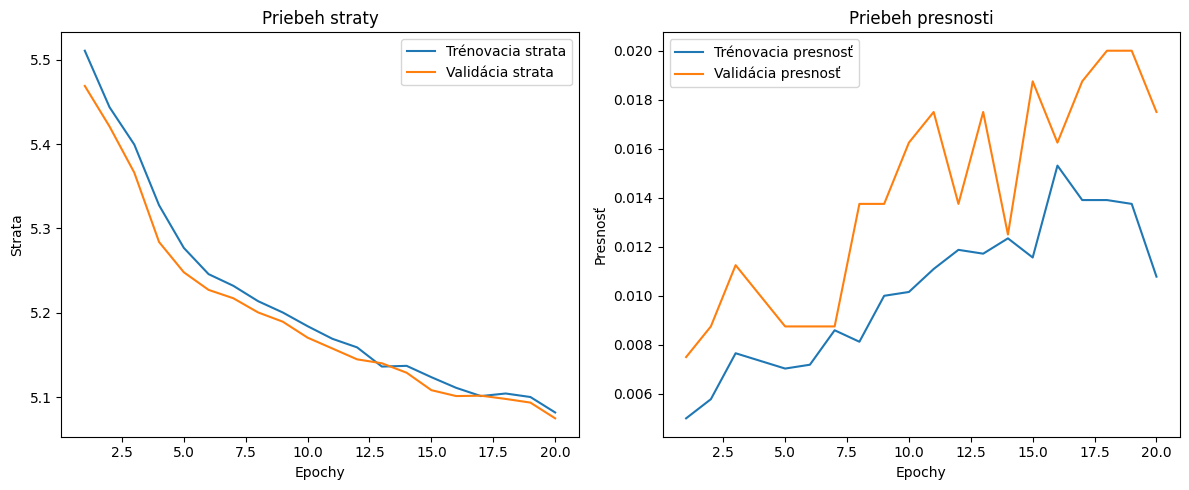

200/200 ━━━━━━━━━━━━━━━━━━━━ 56s 278ms/step


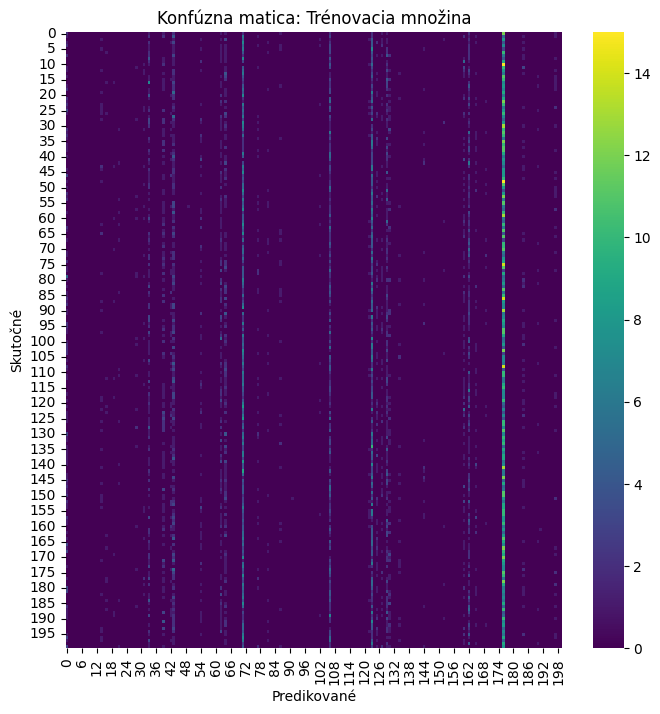

25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 288ms/step


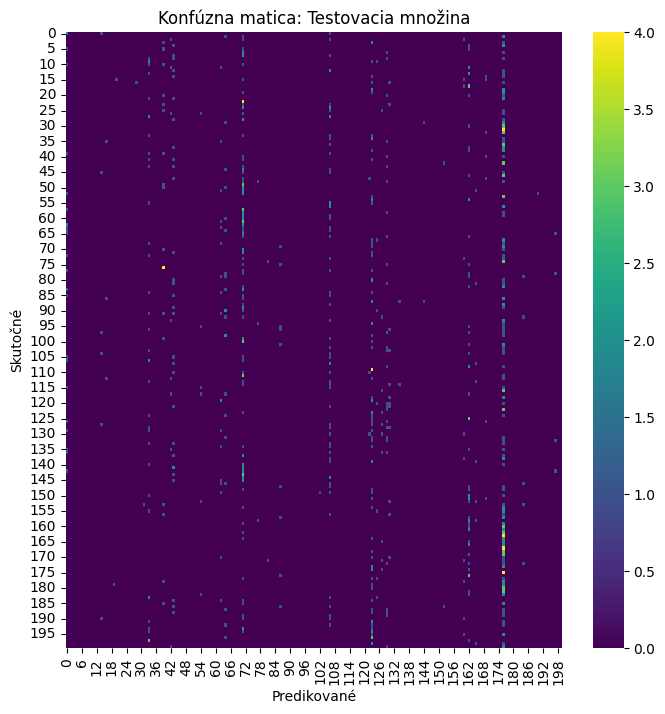

In [80]:
# Funkcia na vykreslenie priebehu trénovania
def plot_training_history(history):
    epochs = range(1, len(history.history['loss']) + 1)
    
    # Strata
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], label='Trénovacia strata')
    plt.plot(epochs, history.history['val_loss'], label='Validácia strata')
    plt.title('Priebeh straty')
    plt.xlabel('Epochy')
    plt.ylabel('Strata')
    plt.legend()
    
    # Presnosť
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['accuracy'], label='Trénovacia presnosť')
    plt.plot(epochs, history.history['val_accuracy'], label='Validácia presnosť')
    plt.title('Priebeh presnosti')
    plt.xlabel('Epochy')
    plt.ylabel('Presnosť')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Funkcia na vykreslenie zjednodušenej konfúznej matice
def plot_confusion_matrix(generator, dataset_name):
    y_true = generator.classes
    y_pred = np.argmax(model.predict(generator), axis=1)
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=False, cmap='viridis', cbar=True)
    plt.title(f'Konfúzna matica: {dataset_name}')
    plt.xlabel('Predikované')
    plt.ylabel('Skutočné')
    plt.show()

# Vykreslenie priebehu trénovania
plot_training_history(history)

# Vykreslenie konfúznych matíc
plot_confusion_matrix(train_generator, "Trénovacia množina")
plot_confusion_matrix(test_generator, "Testovacia množina")

In [11]:
### 3. úloha

# Inicializácia MobileNetV2 na extrakciu príznakov
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
feature_extractor = Model(inputs=base_model.input, outputs=GlobalAveragePooling2D()(base_model.output))

# Generovanie dát
datagen = ImageDataGenerator(rescale=1.0 / 255.0)
generator = datagen.flow_from_directory(
    directory=train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Zachovať poradie obrázkov
)

# Správny počet obrázkov
num_samples = generator.samples  # Celkový počet obrázkov
batch_size = generator.batch_size  # Veľkosť batchu

features = []
labels = []
filepaths = []

# Prechod cez generátor presne podľa počtu batchov
for i in range(len(generator)):
    batch_images, batch_labels = generator[i]
    batch_features = feature_extractor.predict(batch_images)
    
    # Pridanie príznakov, labelov a filepaths
    features.append(batch_features)
    labels.extend(np.argmax(batch_labels, axis=1))  # Konvertovanie one-hot na čísla
    filepaths.extend(generator.filepaths[i * batch_size : (i + 1) * batch_size])

# Skombinovanie príznakov do jednej matice
features = np.vstack(features)  # Skombinovanie všetkých batchov

# Kontrola veľkostí
print(f"Počet príznakov: {features.shape[0]}")
print(f"Počet štítkov: {len(labels)}")
print(f"Počet súborov: {len(filepaths)}")

# Vytvorenie DataFrame
df = pd.DataFrame(features)
df['label'] = labels
df['filepath'] = filepaths

# Uloženie DataFrame
df.to_csv('features_dataset.csv', index=False)
print("Príznaky a cesty k obrázkom boli úspešne uložené.")

Found 6400 images belonging to 200 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━

In [12]:
# Zníženie dimenzie na 2 pre vizualizáciu
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)

# Zhlukovanie
kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(reduced_features)

# Pridanie zhlukov do DataFrame
df['cluster'] = clusters

# Uloženie výsledkov
df.to_csv('clustered_features.csv', index=False)
print("Zhluky boli pridané do clustered_features.csv.")

c:\Users\mraff\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\mraff\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


Zhluky boli pridané do clustered_features.csv.


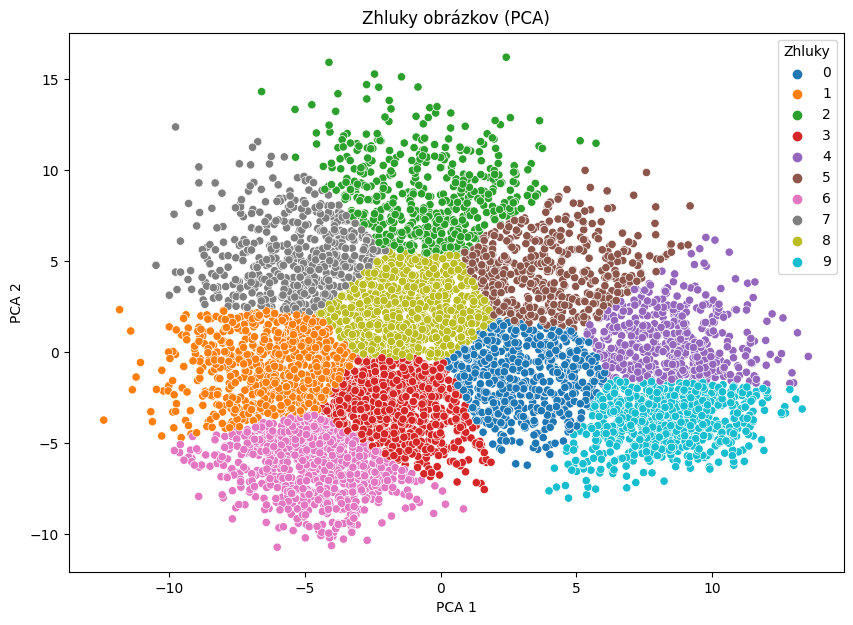

In [13]:
plt.figure(figsize=(10, 7))
sns.scatterplot(x=reduced_features[:, 0], y=reduced_features[:, 1], hue=clusters, palette='tab10')
plt.title("Zhluky obrázkov (PCA)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Zhluky")
#plt.show()

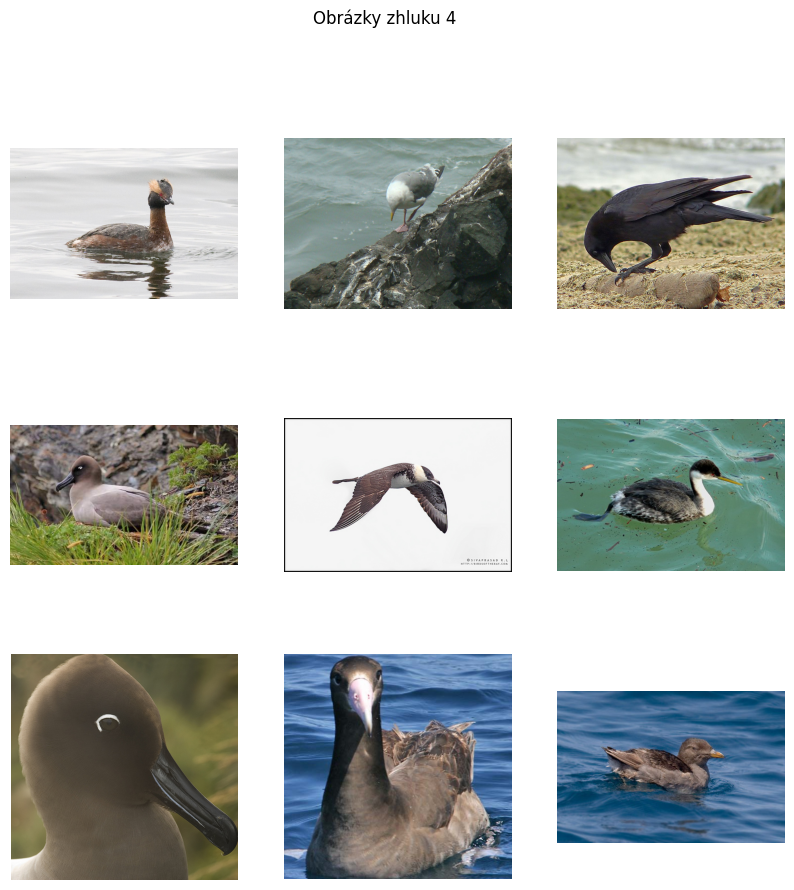

In [14]:
# Zobrazenie podmnožiny obrázkov pre každý zhluk:
# Výber obrázkov pre zhluk
cluster_id = 4 # Vyber zhluk na zobrazenie
cluster_images = df[df['cluster'] == cluster_id]['filepath'].sample(9)

# Zobrazenie obrázkov
plt.figure(figsize=(10, 10))
for i, img_path in enumerate(cluster_images):
    img = mpimg.imread(img_path)
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.suptitle(f"Obrázky zhluku {cluster_id}")
plt.show()

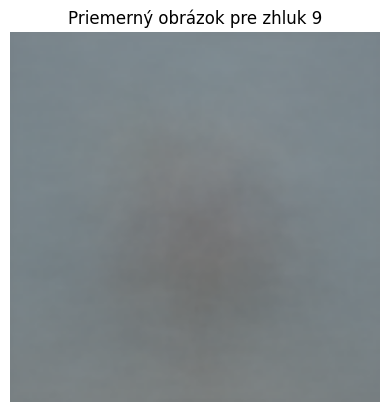

In [20]:
# Načítanie ciest k obrázkom pre zhluk
cluster_id =9
cluster_filepaths = df[df['cluster'] == cluster_id]['filepath']

images = []
for fp in cluster_filepaths:
    # Načítanie obrázku
    img = Image.open(fp).resize((128, 128))
    
    # Konverzia na RGB, ak obrázok nemá 3 kanály
    if img.mode != 'RGB':
        img = ImageOps.grayscale(img).convert('RGB')
    
    # Pridanie obrázku do zoznamu
    images.append(np.array(img))

# Výpočet priemerného obrázku
average_image = np.mean(images, axis=0).astype(np.uint8)

# Vykreslenie priemerného obrázku
plt.imshow(average_image)
plt.title(f"Priemerný obrázok pre zhluk {cluster_id}")
plt.axis('off')
plt.show()

Epoch 1/50


c:\Users\mraff\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0061 - loss: 5.6179 - val_accuracy: 0.0437 - val_loss: 5.1385
Epoch 2/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0248 - loss: 5.0839 - val_accuracy: 0.1016 - val_loss: 4.6345
Epoch 3/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0593 - loss: 4.6924 - val_accuracy: 0.1430 - val_loss: 4.1183
Epoch 4/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0942 - loss: 4.2901 - val_accuracy: 0.1852 - val_loss: 3.7274
Epoch 5/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1189 - loss: 3.9699 - val_accuracy: 0.2188 - val_loss: 3.4462
Epoch 6/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1313 - loss: 3.7435 - val_accuracy: 0.2570 - val_loss: 3.2465
Epoch 7/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1613 - loss: 3.5165 - val_accuracy: 0.2695 - val_loss: 3.0674
Epoch 8/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1964 - loss: 3.3584 - val_accuracy: 0.2844 - val_

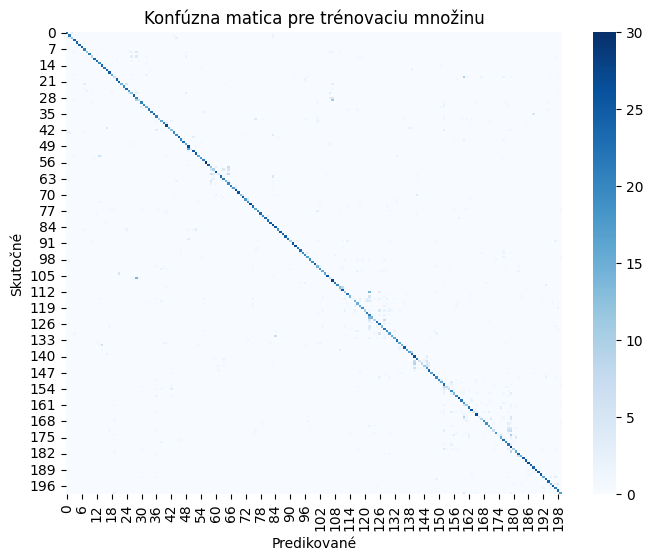

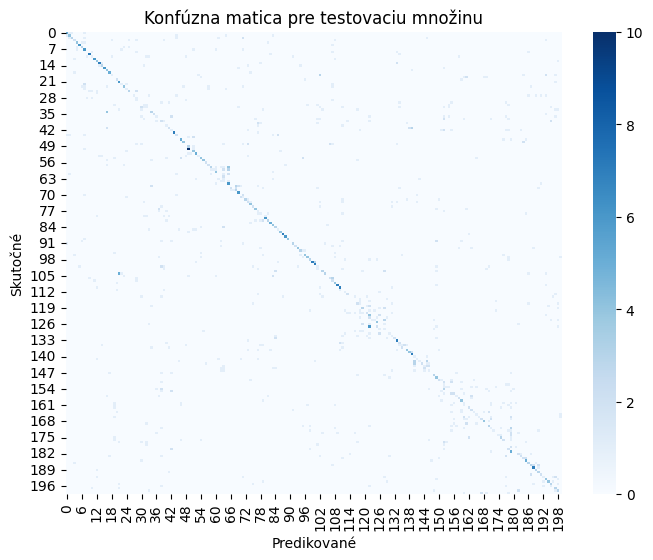

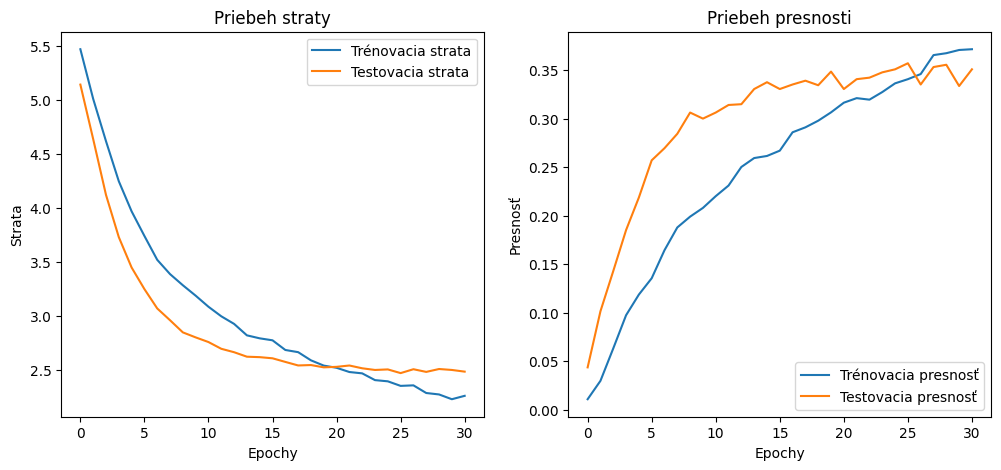

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

# Split na trénovaciu a testovaciu množinu
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Normalizácia príznakov
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Prevod labelov na one-hot encoding
y_train_onehot = to_categorical(y_train)
y_test_onehot = to_categorical(y_test)

# Model s Dropout na zníženie overfittingu
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.5),  # Dropout na zníženie overfittingu
    Dense(64, activation='relu'),
    Dropout(0.5),  # Dropout na zníženie overfittingu
    Dense(len(set(y_train)), activation='softmax')
])

# Kompilácia modelu
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping pre zamedzenie overfittingu
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Trénovanie modelu
history = model.fit(X_train, y_train_onehot, epochs=50, batch_size=32, validation_data=(X_test, y_test_onehot), callbacks=[early_stopping])

# Vyhodnotenie modelu
train_loss, train_accuracy = model.evaluate(X_train, y_train_onehot)
test_loss, test_accuracy = model.evaluate(X_test, y_test_onehot)

print(f'Trénovacia presnosť: {train_accuracy*100:.2f}%')
print(f'Testovacia presnosť: {test_accuracy*100:.2f}%')

# Vykreslenie konfúznej matice pre trénovaciu a testovaciu množinu bez labelov
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

y_train_pred_class = y_train_pred.argmax(axis=1)
y_test_pred_class = y_test_pred.argmax(axis=1)

# Konfúzna matica pre trénovaciu množinu
cm_train = confusion_matrix(y_train, y_train_pred_class)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=False, fmt='d', cmap='Blues')  # Vykreslenie bez labelov
plt.title('Konfúzna matica pre trénovaciu množinu')
plt.xlabel('Predikované')
plt.ylabel('Skutočné')
plt.show()

# Konfúzna matica pre testovaciu množinu
cm_test = confusion_matrix(y_test, y_test_pred_class)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=False, fmt='d', cmap='Blues')  # Vykreslenie bez labelov
plt.title('Konfúzna matica pre testovaciu množinu')
plt.xlabel('Predikované')
plt.ylabel('Skutočné')
plt.show()

# Zobrazenie priebehu trénovania (loss a accuracy) pre trénovaciu a testovaciu množinu
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Trénovacia strata')
plt.plot(history.history['val_loss'], label='Testovacia strata')
plt.title('Priebeh straty')
plt.xlabel('Epochy')
plt.ylabel('Strata')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Trénovacia presnosť')
plt.plot(history.history['val_accuracy'], label='Testovacia presnosť')
plt.title('Priebeh presnosti')
plt.xlabel('Epochy')
plt.ylabel('Presnosť')
plt.legend()

plt.show()



Epoch 1/50


c:\Users\mraff\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.0052 - loss: 6.5592 - val_accuracy: 0.0265 - val_loss: 6.1421
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0276 - loss: 6.0202 - val_accuracy: 0.0531 - val_loss: 5.8137
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0632 - loss: 5.5877 - val_accuracy: 0.0354 - val_loss: 5.5430
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0344 - loss: 5.3531 - val_accuracy: 0.0265 - val_loss: 5.3514
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0603 - loss: 5.0986 - val_accuracy: 0.0619 - val_loss: 5.2049
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0813 - loss: 4.8182 - val_accuracy: 0.0531 - val_loss: 5.0725
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0816 - loss: 4.7308 - val_accuracy: 0.0619 - val_loss: 4.9767
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1229 - loss: 4.5255 - val_accuracy: 0.0885 - val_loss: 4.9045
Ep

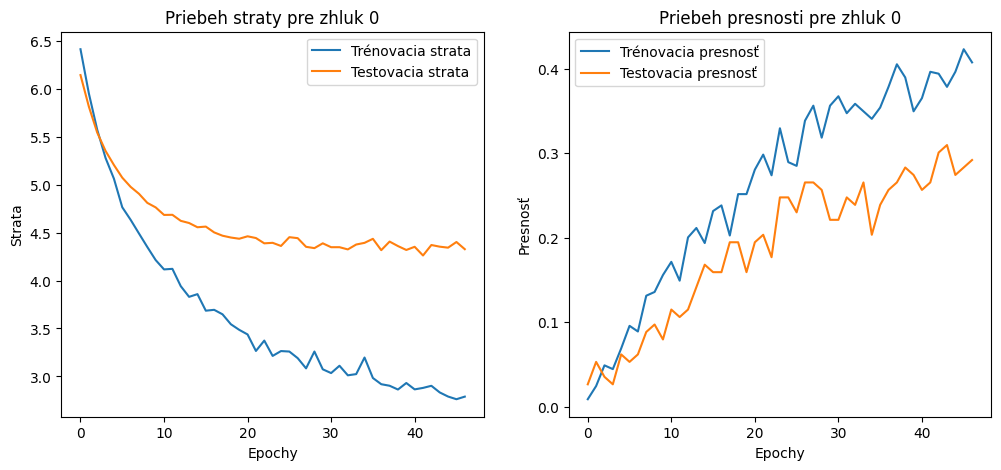

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


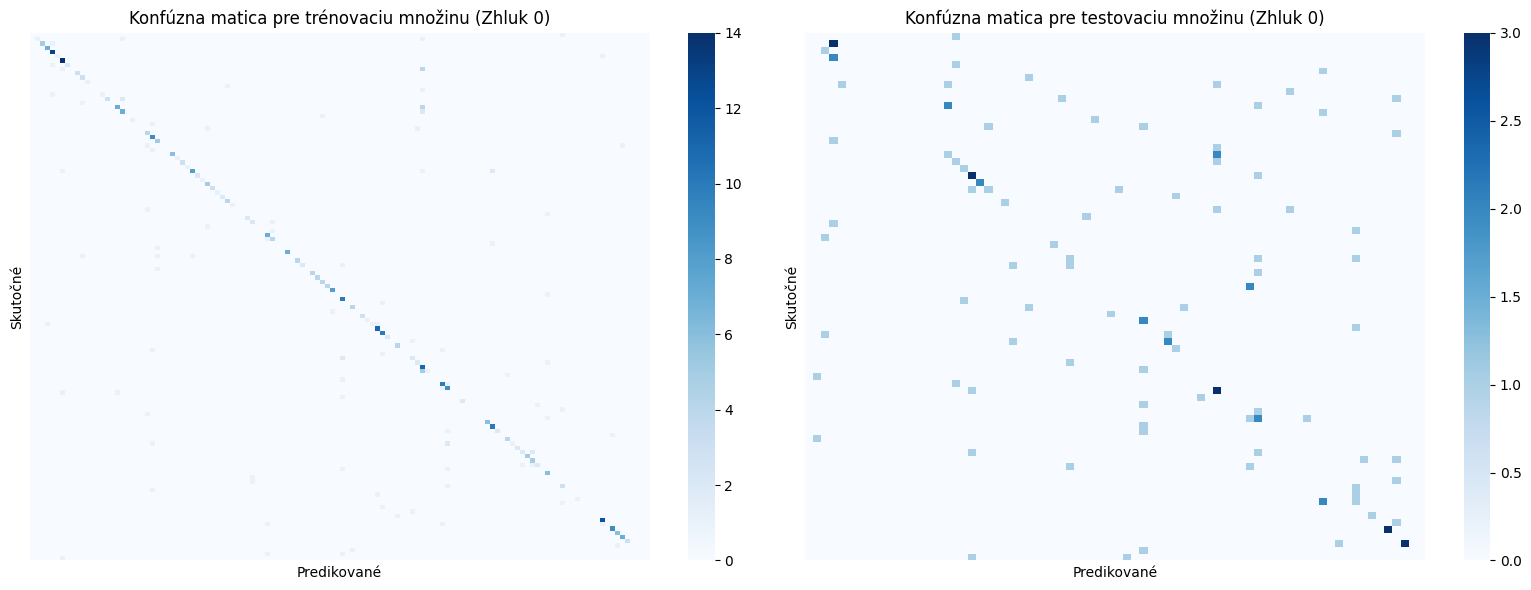

Epoch 1/50


c:\Users\mraff\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0026 - loss: 6.4443 - val_accuracy: 0.0063 - val_loss: 5.9388
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0111 - loss: 5.8142 - val_accuracy: 0.0253 - val_loss: 5.5784
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0264 - loss: 5.4727 - val_accuracy: 0.0253 - val_loss: 5.3465
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0400 - loss: 5.1439 - val_accuracy: 0.0316 - val_loss: 5.1544
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0334 - loss: 4.9722 - val_accuracy: 0.0127 - val_loss: 5.0003
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0407 - loss: 4.7475 - val_accuracy: 0.0190 - val_loss: 4.8931
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0541 - loss: 4.6663 - val_accuracy: 0.0380 - val_loss: 4.7968
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0780 - loss: 4.4543 - val_accuracy: 0.0253 - val_loss: 4.6957
Epo

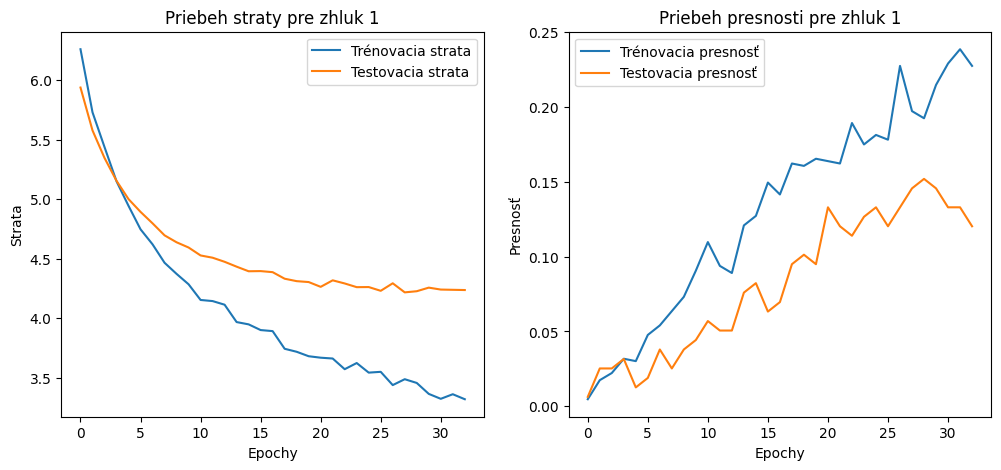

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


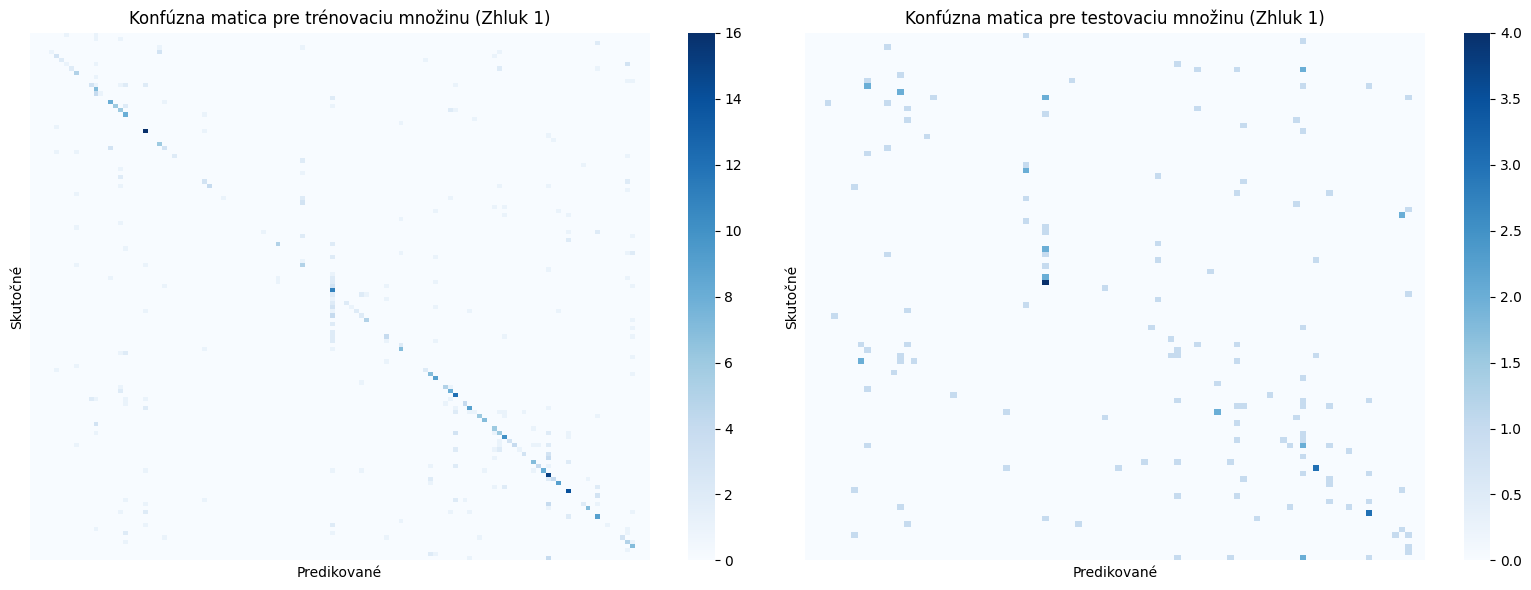

Epoch 1/50


c:\Users\mraff\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.0119 - loss: 6.4867 - val_accuracy: 0.0388 - val_loss: 6.0998
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0306 - loss: 6.0026 - val_accuracy: 0.0583 - val_loss: 5.8121
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0409 - loss: 5.7462 - val_accuracy: 0.0583 - val_loss: 5.5934
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0657 - loss: 5.3917 - val_accuracy: 0.0874 - val_loss: 5.3667
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0431 - loss: 5.2487 - val_accuracy: 0.0680 - val_loss: 5.1793
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0482 - loss: 5.0781 - val_accuracy: 0.0485 - val_loss: 5.0574
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0923 - loss: 4.8214 - val_accuracy: 0.1165 - val_loss: 4.9078
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1070 - loss: 4.5329 - val_accuracy: 0.1359 - val_loss: 4.8170
Epo

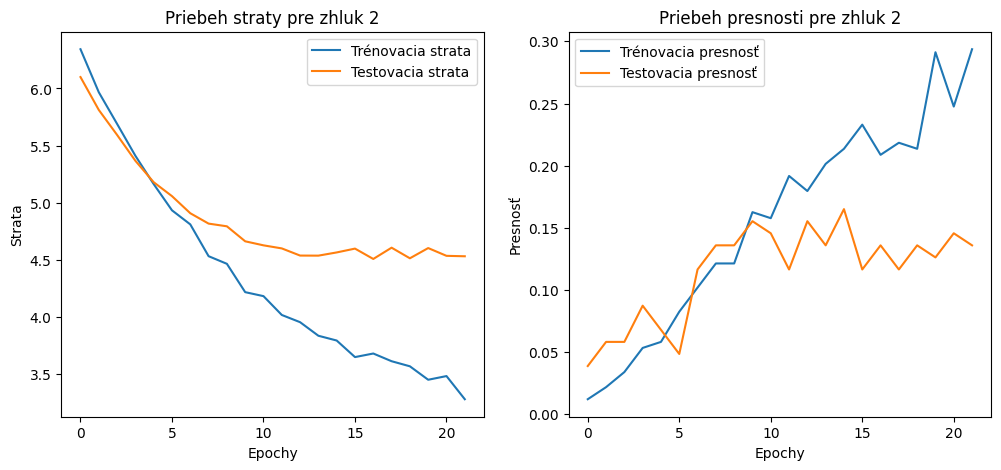

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


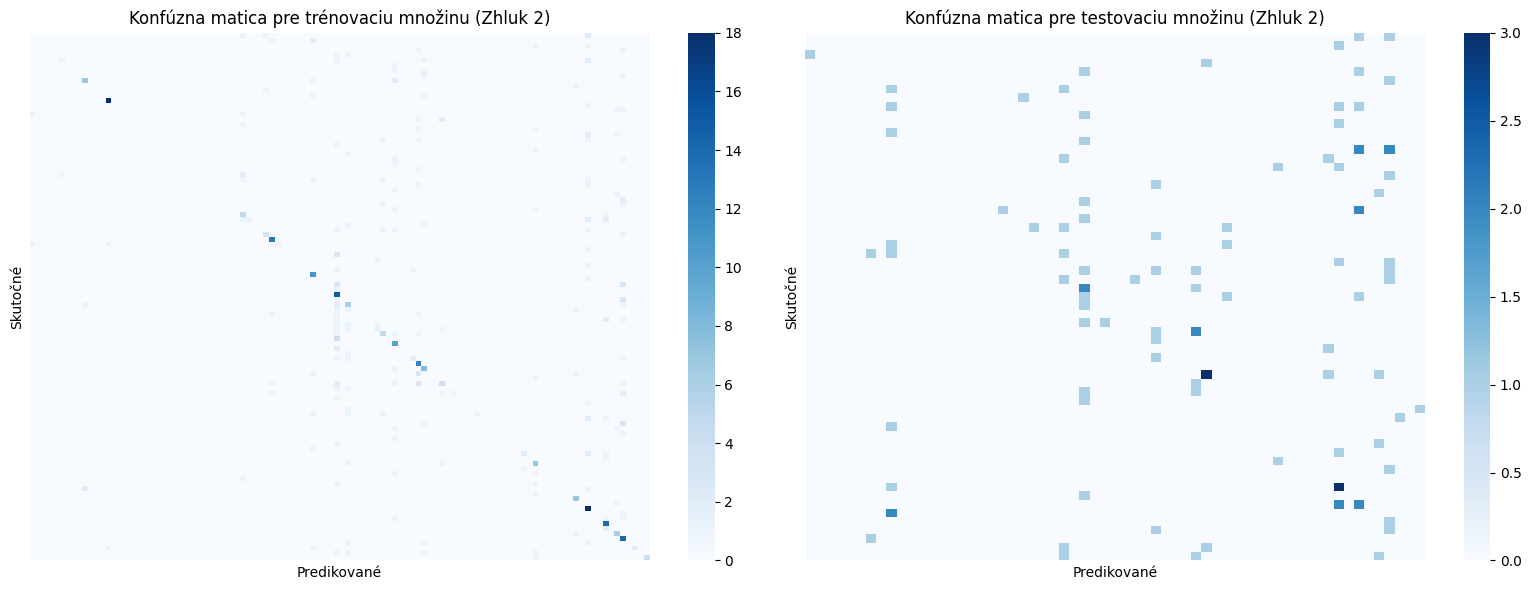

Epoch 1/50


c:\Users\mraff\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.0018 - loss: 6.5393 - val_accuracy: 0.0132 - val_loss: 6.0947
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0268 - loss: 5.9466 - val_accuracy: 0.0530 - val_loss: 5.7276
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0312 - loss: 5.5504 - val_accuracy: 0.0596 - val_loss: 5.4518
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0495 - loss: 5.2532 - val_accuracy: 0.0795 - val_loss: 5.2571
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0957 - loss: 4.9265 - val_accuracy: 0.0861 - val_loss: 5.1112
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0857 - loss: 4.7744 - val_accuracy: 0.1126 - val_loss: 4.9424
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1164 - loss: 4.5659 - val_accuracy: 0.1126 - val_loss: 4.8505
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1490 - loss: 4.4182 - val_accuracy: 0.1192 - val_loss: 4.7274
Epo

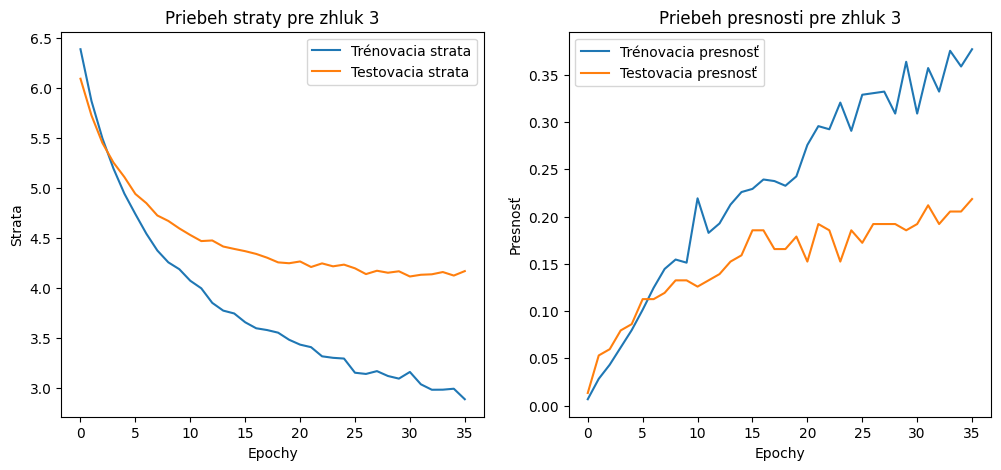

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


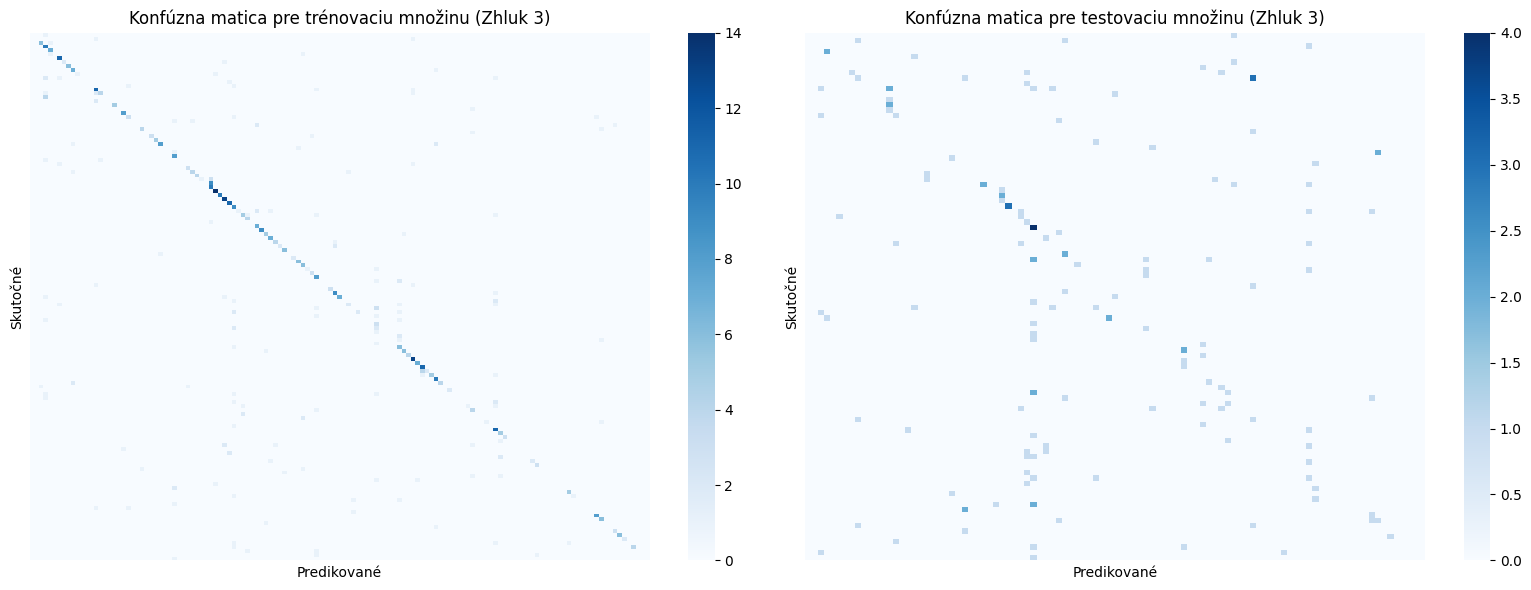

Epoch 1/50


c:\Users\mraff\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.0247 - loss: 6.0407 - val_accuracy: 0.0196 - val_loss: 5.6422
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0283 - loss: 5.5578 - val_accuracy: 0.0196 - val_loss: 5.3682
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0430 - loss: 5.2145 - val_accuracy: 0.0588 - val_loss: 5.0987
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0634 - loss: 4.9286 - val_accuracy: 0.0588 - val_loss: 4.9310
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0709 - loss: 4.7043 - val_accuracy: 0.0686 - val_loss: 4.7558
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1265 - loss: 4.4180 - val_accuracy: 0.0490 - val_loss: 4.6503
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1276 - loss: 4.1980 - val_accuracy: 0.0882 - val_loss: 4.5452
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1545 - loss: 4.0611 - val_accuracy: 0.0784 - val_loss: 4.4737
Ep

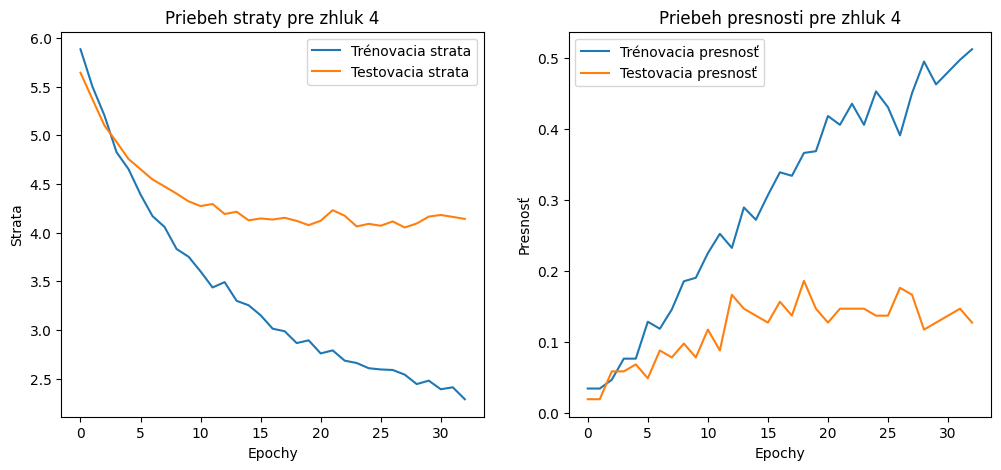

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


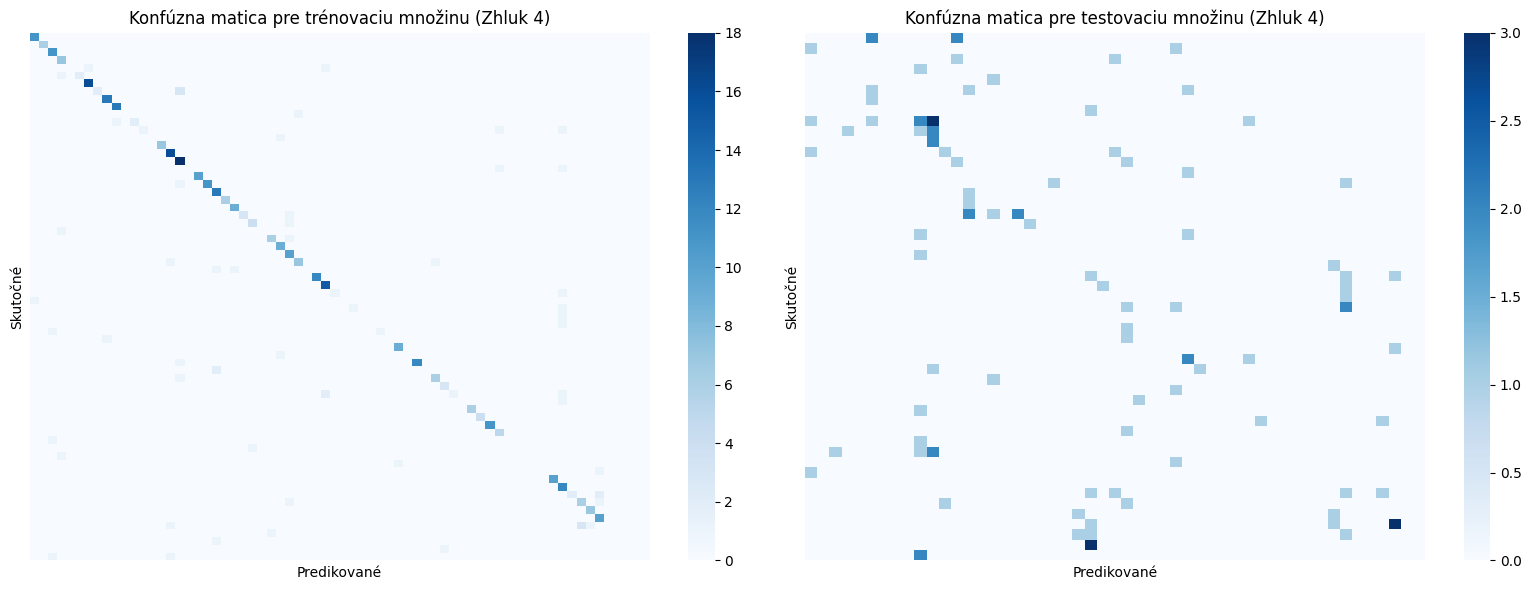

Epoch 1/50


c:\Users\mraff\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0017 - loss: 6.6991 - val_accuracy: 0.0300 - val_loss: 6.3374
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0152 - loss: 6.2385 - val_accuracy: 0.0100 - val_loss: 6.0861
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0192 - loss: 5.9316 - val_accuracy: 0.0300 - val_loss: 5.8701
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0325 - loss: 5.6441 - val_accuracy: 0.0800 - val_loss: 5.6215
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0489 - loss: 5.3098 - val_accuracy: 0.0500 - val_loss: 5.4727
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0692 - loss: 5.0863 - val_accuracy: 0.1100 - val_loss: 5.3119
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0826 - loss: 4.8914 - val_accuracy: 0.1400 - val_loss: 5.1973
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0843 - loss: 4.7303 - val_accuracy: 0.1300 - val_loss: 5.0930
Epo

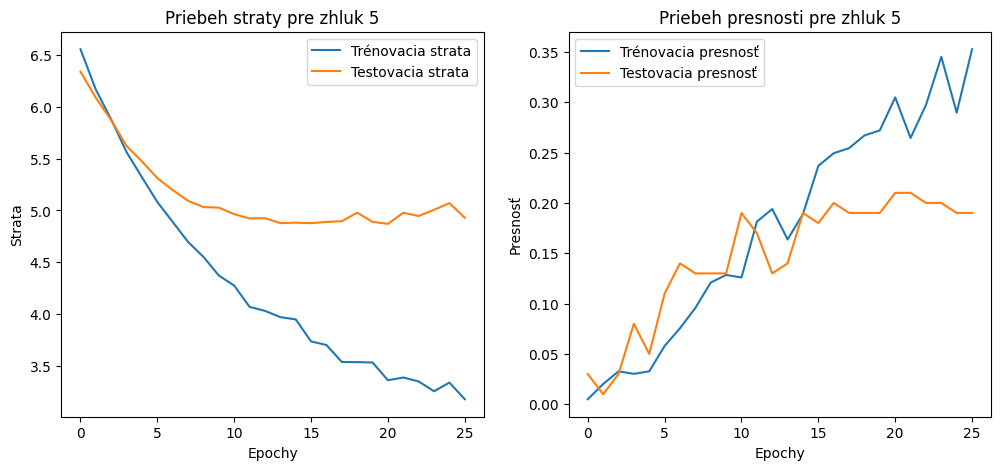

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


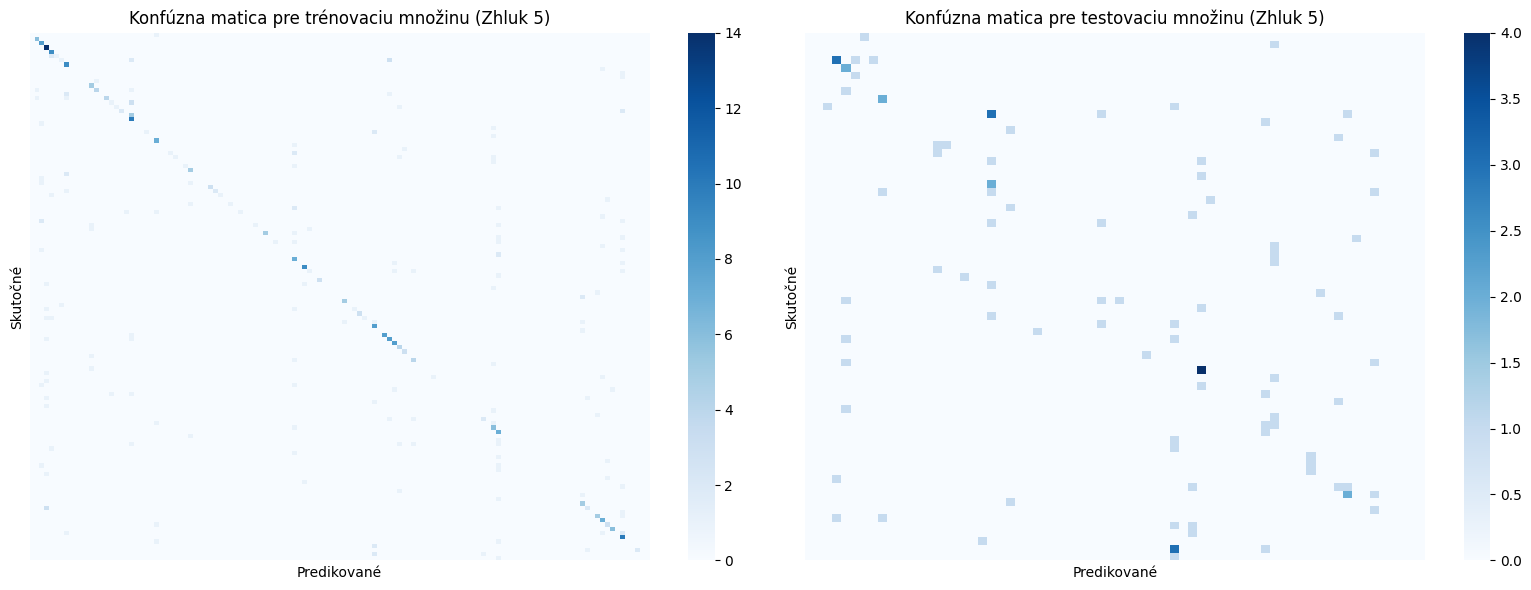

Epoch 1/50


c:\Users\mraff\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0097 - loss: 6.2513 - val_accuracy: 0.0241 - val_loss: 5.6516
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0385 - loss: 5.5451 - val_accuracy: 0.0602 - val_loss: 5.1944
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0507 - loss: 5.1354 - val_accuracy: 0.1024 - val_loss: 4.7821
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0797 - loss: 4.6923 - val_accuracy: 0.1084 - val_loss: 4.4620
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0974 - loss: 4.4049 - val_accuracy: 0.1265 - val_loss: 4.3059
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1240 - loss: 4.2363 - val_accuracy: 0.1386 - val_loss: 4.1292
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1445 - loss: 3.9886 - val_accuracy: 0.1747 - val_loss: 3.9469
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1907 - loss: 3.8399 - val_accuracy: 0.1928 - val_loss: 3.8589
Epo

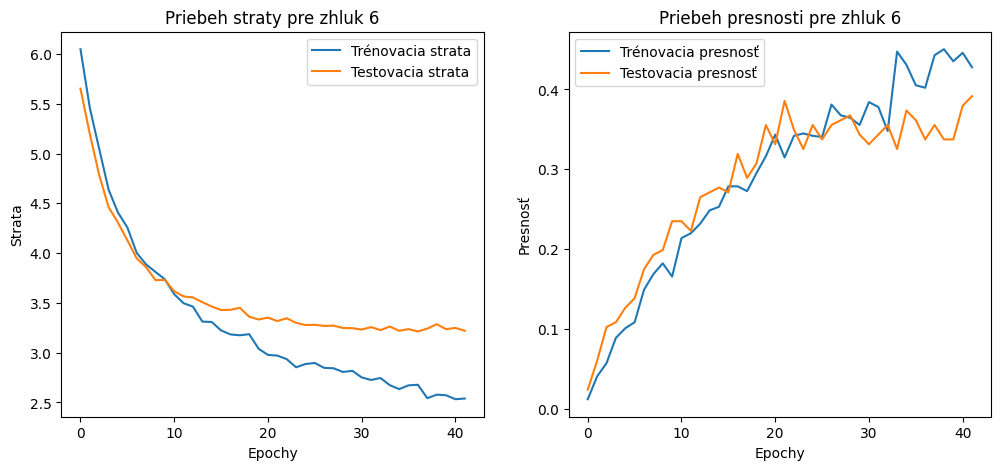

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


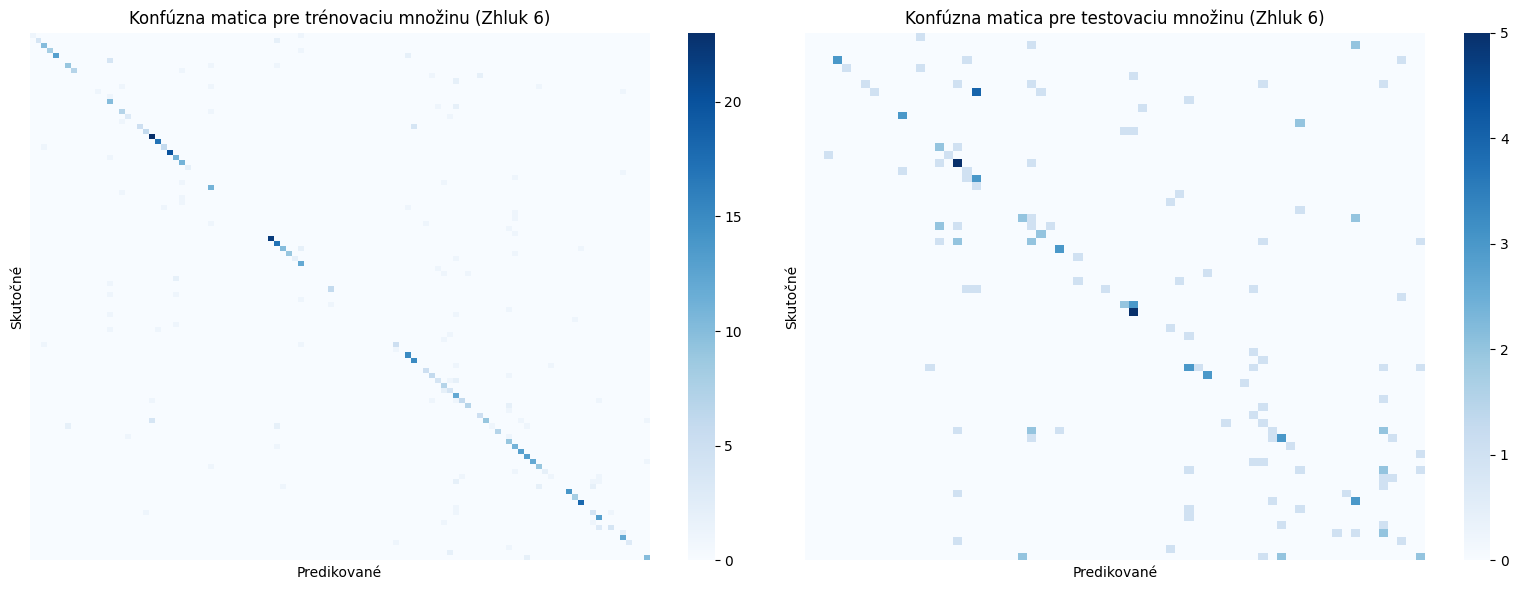

Epoch 1/50


c:\Users\mraff\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.0116 - loss: 6.4946 - val_accuracy: 0.0291 - val_loss: 6.1190
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0253 - loss: 6.0062 - val_accuracy: 0.0388 - val_loss: 5.8463
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0429 - loss: 5.7004 - val_accuracy: 0.0583 - val_loss: 5.6661
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0139 - loss: 5.5352 - val_accuracy: 0.0583 - val_loss: 5.4676
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0262 - loss: 5.3069 - val_accuracy: 0.0680 - val_loss: 5.3357
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0501 - loss: 5.0800 - val_accuracy: 0.0583 - val_loss: 5.2049
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0585 - loss: 4.9642 - val_accuracy: 0.0680 - val_loss: 5.1664
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0593 - loss: 4.8238 - val_accuracy: 0.0583 - val_loss: 5.0491
Epo

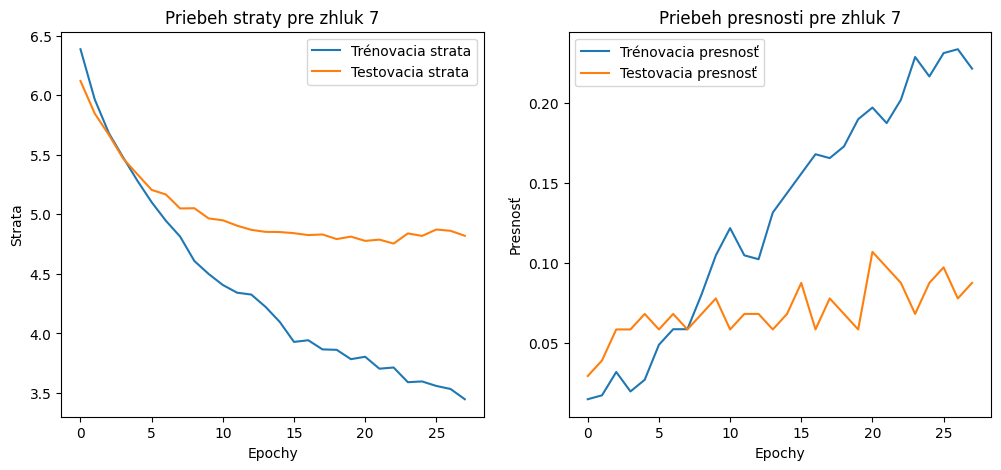

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


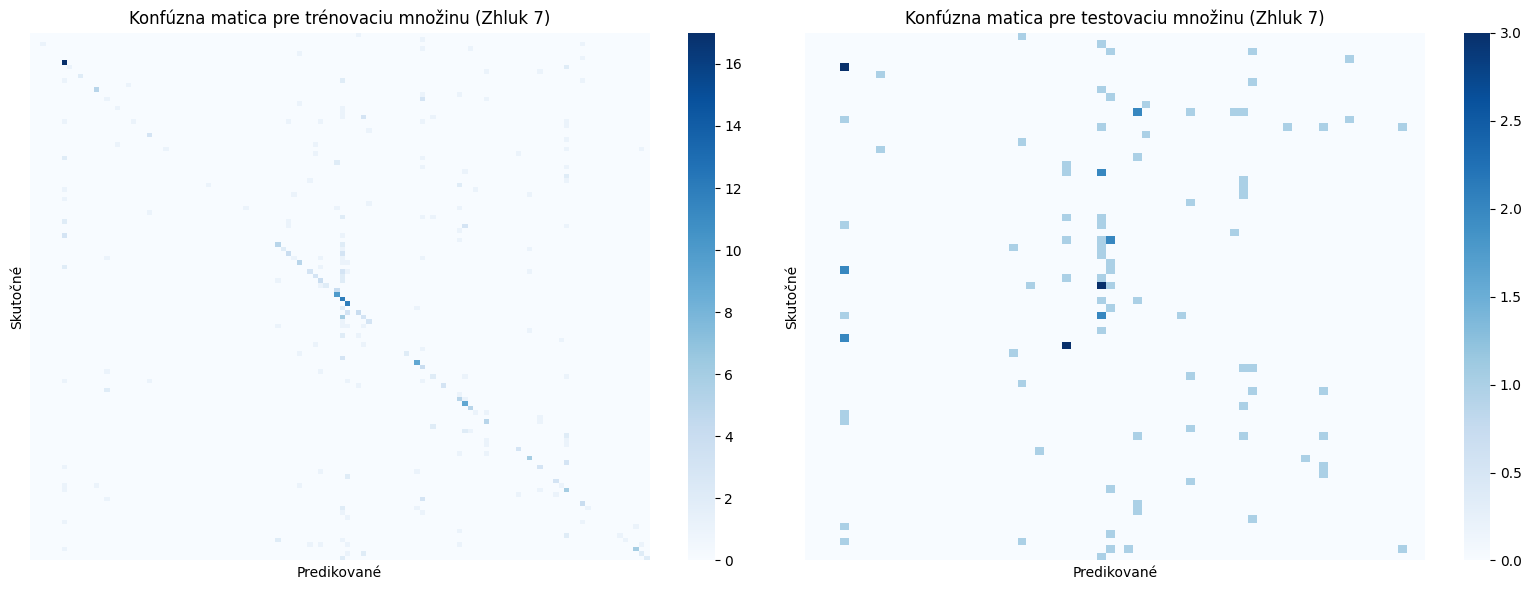

Epoch 1/50


c:\Users\mraff\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0083 - loss: 6.6583 - val_accuracy: 0.0067 - val_loss: 6.2514
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0145 - loss: 6.1463 - val_accuracy: 0.0200 - val_loss: 5.9473
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0418 - loss: 5.7841 - val_accuracy: 0.0133 - val_loss: 5.7317
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0238 - loss: 5.5069 - val_accuracy: 0.0267 - val_loss: 5.5193
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0616 - loss: 5.2940 - val_accuracy: 0.0333 - val_loss: 5.3959
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0500 - loss: 5.1098 - val_accuracy: 0.0467 - val_loss: 5.2925
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0677 - loss: 4.9724 - val_accuracy: 0.0533 - val_loss: 5.1991
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1049 - loss: 4.7887 - val_accuracy: 0.0400 - val_loss: 5.1045
Epo

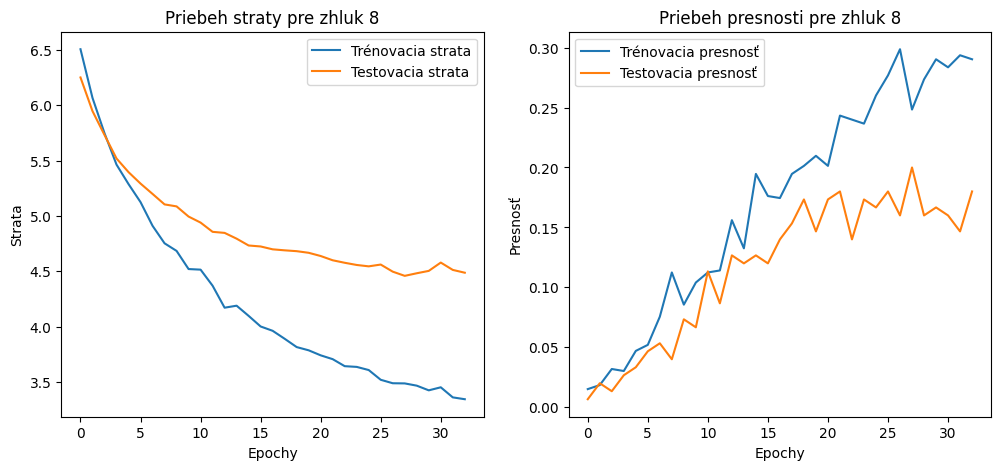

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


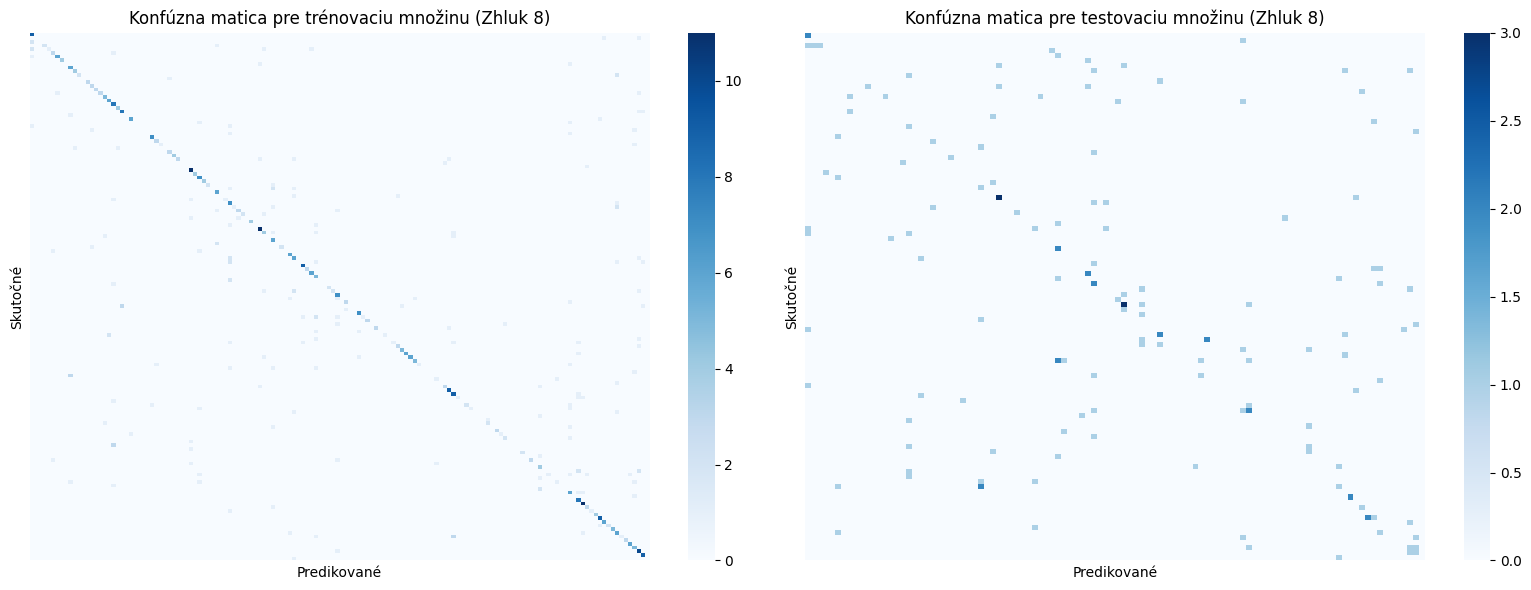

Epoch 1/50


c:\Users\mraff\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0164 - loss: 5.7077 - val_accuracy: 0.0435 - val_loss: 5.1389
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0467 - loss: 5.0461 - val_accuracy: 0.1377 - val_loss: 4.6934
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1021 - loss: 4.5530 - val_accuracy: 0.1884 - val_loss: 4.3489
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1626 - loss: 4.1702 - val_accuracy: 0.1812 - val_loss: 4.0477
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2188 - loss: 3.8296 - val_accuracy: 0.2464 - val_loss: 3.7869
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2120 - loss: 3.6703 - val_accuracy: 0.2391 - val_loss: 3.6649
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2293 - loss: 3.5272 - val_accuracy: 0.2609 - val_loss: 3.4925
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2492 - loss: 3.4337 - val_accuracy: 0.2826 - val_loss: 3.3274
Epo

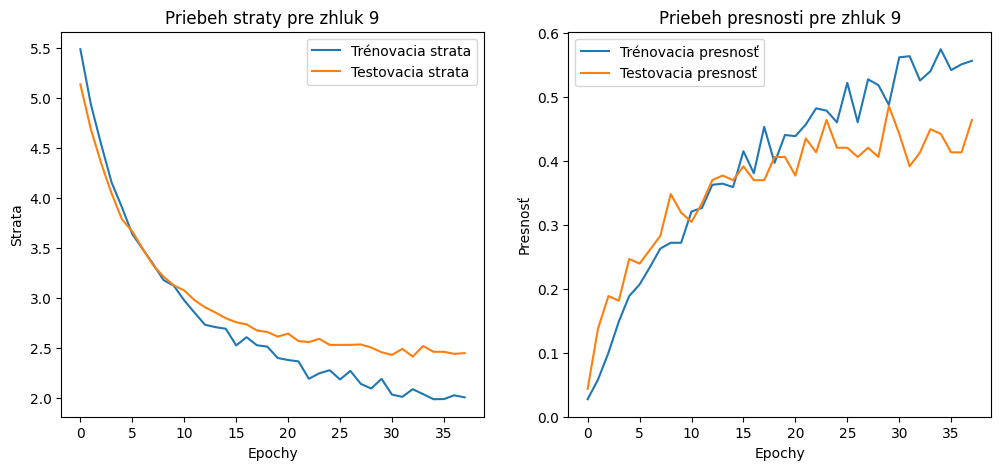

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


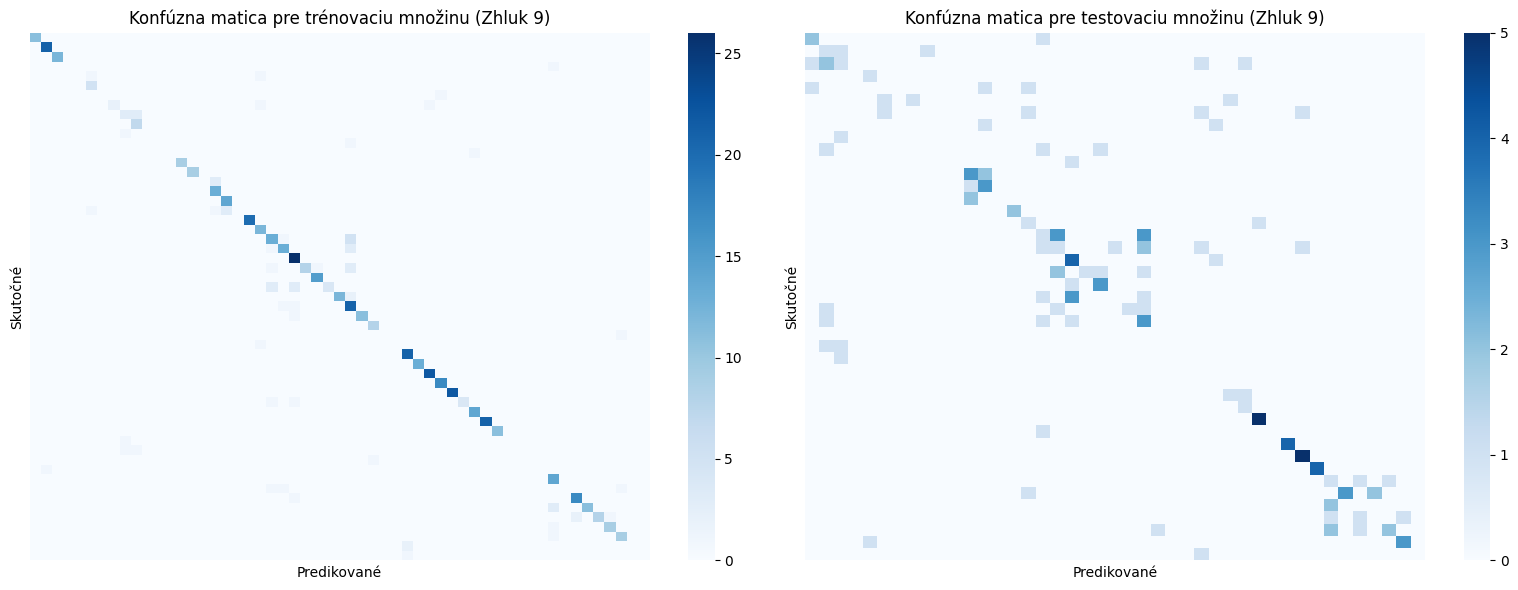

Zhluk s najlepšou testovacou presnosťou: Zhluk 9 (41.30%)
Zhluk s najhoršou testovacou presnosťou: Zhluk 7 (8.74%)


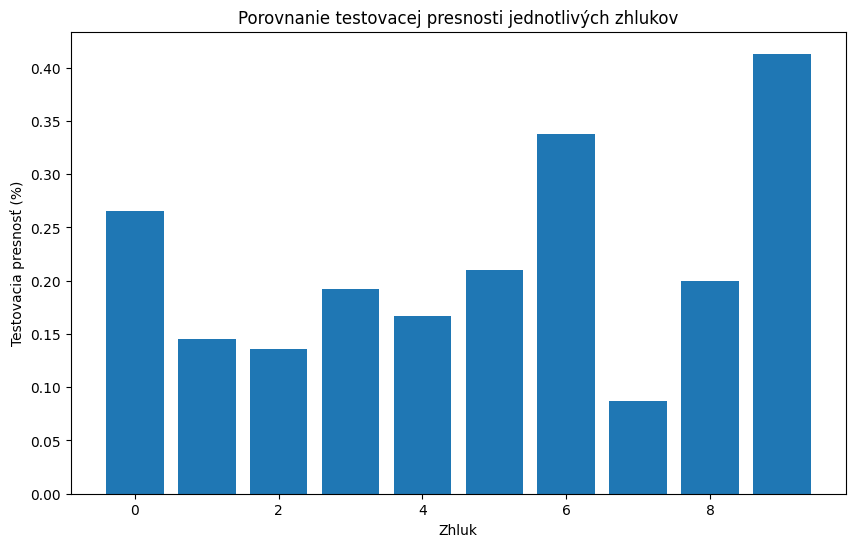

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Predpokladám, že už máš pripravené 'early_stopping' callback, ak ho používaš
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# Inicializácia zoznamov na ukladanie výsledkov pre analýzu
train_accuracies = []
test_accuracies = []



for cluster_num in np.unique(clusters):
    
    # Výber vzoriek
    cluster_indices = [i for i, c in enumerate(clusters) if c == cluster_num]
    X_cluster = np.array(features)[cluster_indices]
    y_cluster = labels[cluster_indices]

    # Zarovnanie tried
    label_encoder = LabelEncoder()
    y_cluster_encoded = label_encoder.fit_transform(y_cluster)

    # Rozdelenie na trénovaciu a testovaciu množinu
    X_train_cluster, X_test_cluster, y_train_cluster, y_test_cluster = train_test_split(
        X_cluster, y_cluster_encoded, test_size=0.2, random_state=42
    )

    # Počet tried
    num_classes = len(np.unique(y_cluster_encoded))

    # One-hot encoding
    y_train_cluster_onehot = to_categorical(y_train_cluster, num_classes=num_classes)
    y_test_cluster_onehot = to_categorical(y_test_cluster, num_classes=num_classes)


   # Upravený model s regularizáciou a dropout
    model = Sequential([
        Dense(64, activation='relu', input_dim=X_train_cluster.shape[1], kernel_regularizer=l2(0.01)),
        Dropout(0.4),  # Dropout vrstva
        Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.4),  # Dropout vrstva
        Dense(num_classes, activation='softmax')
    ])

    # Upravené nastavenia kompilácie modelu
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Zavedenie early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Trénovanie modelu s early stopping
    history_cluster = model.fit(
        X_train_cluster, y_train_cluster_onehot,
        epochs=50,  # Pôvodný počet epoch zvýšený, ale early stopping to zastaví, keď sa strata nebude zlepšovať
        batch_size=16,
        validation_data=(X_test_cluster, y_test_cluster_onehot),
        callbacks=[early_stopping]
    )



    # Vyhodnotenie modelu pre daný zhluk
    cluster_train_loss, cluster_train_accuracy = model.evaluate(X_train_cluster, y_train_cluster_onehot)
    cluster_test_loss, cluster_test_accuracy = model.evaluate(X_test_cluster, y_test_cluster_onehot)

    # Ukladanie presností pre analýzu
    train_accuracies.append(cluster_train_accuracy)
    test_accuracies.append(cluster_test_accuracy)

    print(f'Zhluk {cluster_num}:')
    print(f'  Trénovacia presnosť: {cluster_train_accuracy*100:.2f}%')
    print(f'  Testovacia presnosť: {cluster_test_accuracy*100:.2f}%')

    # Vykreslenie priebehu trénovania pre daný zhluk
    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history_cluster.history['loss'], label='Trénovacia strata')
    plt.plot(history_cluster.history['val_loss'], label='Testovacia strata')
    plt.title(f'Priebeh straty pre zhluk {cluster_num}')
    plt.xlabel('Epochy')
    plt.ylabel('Strata')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history_cluster.history['accuracy'], label='Trénovacia presnosť')
    plt.plot(history_cluster.history['val_accuracy'], label='Testovacia presnosť')
    plt.title(f'Priebeh presnosti pre zhluk {cluster_num}')
    plt.xlabel('Epochy')
    plt.ylabel('Presnosť')
    plt.legend()

    plt.show()

    # Konfúzna matica pre daný zhluk
    y_train_cluster_pred = model.predict(X_train_cluster)
    y_test_cluster_pred = model.predict(X_test_cluster)

    y_train_cluster_pred_class = y_train_cluster_pred.argmax(axis=1)
    y_test_cluster_pred_class = y_test_cluster_pred.argmax(axis=1)


    cm_train_cluster = confusion_matrix(y_train_cluster, y_train_cluster_pred_class)
    cm_test_cluster = confusion_matrix(y_test_cluster, y_test_cluster_pred_class)
    # Nastavenie obrázka s dvomi grafmi vedľa seba
    # Nastavenie obrázka s dvomi grafmi vedľa seba
    plt.figure(figsize=(16, 6))

    # Prvý subplot - trénovacia množina
    plt.subplot(1, 2, 1)
    sns.heatmap(cm_train_cluster, annot=False, fmt='d', cmap='Blues', cbar=True)
    plt.title(f'Konfúzna matica pre trénovaciu množinu (Zhluk {cluster_num})')
    plt.xlabel('Predikované')
    plt.ylabel('Skutočné')

    # Odstránenie čísel na osiach
    plt.xticks([], [])
    plt.yticks([], [])

    # Druhý subplot - testovacia množina
    plt.subplot(1, 2, 2)
    sns.heatmap(cm_test_cluster, annot=False, fmt='d', cmap='Blues', cbar=True)
    plt.title(f'Konfúzna matica pre testovaciu množinu (Zhluk {cluster_num})')
    plt.xlabel('Predikované')
    plt.ylabel('Skutočné')

    # Odstránenie čísel na osiach
    plt.xticks([], [])
    plt.yticks([], [])

    # Zobrazenie obrázka
    plt.tight_layout()
    plt.show()


# Analýza rozdielov v úspešnosti
best_cluster_idx = np.argmax(test_accuracies)
worst_cluster_idx = np.argmin(test_accuracies)

print(f'Zhluk s najlepšou testovacou presnosťou: Zhluk {np.unique(clusters)[best_cluster_idx]} ({test_accuracies[best_cluster_idx]*100:.2f}%)')
print(f'Zhluk s najhoršou testovacou presnosťou: Zhluk {np.unique(clusters)[worst_cluster_idx]} ({test_accuracies[worst_cluster_idx]*100:.2f}%)')

# Vizualizácia úspešnosti jednotlivých zhlukov
plt.figure(figsize=(10, 6))
plt.bar(np.unique(clusters), test_accuracies)
plt.title('Porovnanie testovacej presnosti jednotlivých zhlukov')
plt.xlabel('Zhluk')
plt.ylabel('Testovacia presnosť (%)')
plt.show()

